In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import calendar
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# Benchmark Processing

Benchmarks are confirmed to be Li2CO3 and LiOH from Wind Database

In [153]:
def wind_process(df, range = 0): # range: default 0 for full, 1 for starting 2021
    
    df.set_index('Date', inplace = True)
    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df.index = pd.to_datetime(df.index)

    if range: df = df[df.index >= '2021-01-01']
    
    df['Price'].replace(0, np.NaN, inplace = True)
    return df

y_full = {
    'li2co3': wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')), # Wind Lithium Carbonate Price
    'lioh': wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')), # Wind Lithium Hydroxide Price
}

y_2021 = {
    'li2co3': wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv'), 1), # Wind Lithium Carbonate Price from 2021
    'lioh': wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv'), 1), # Wind Lithium Hydroxide Price from 2021
}




## Benchmark Zeros
### Monthly Zeros
Around 2014, a lot of days are missing. It has data one or twice a week. Ratios exceed 1 because the denominator is set as 22, one month may include more than 22 days. And in 2017, clusters of data missing.

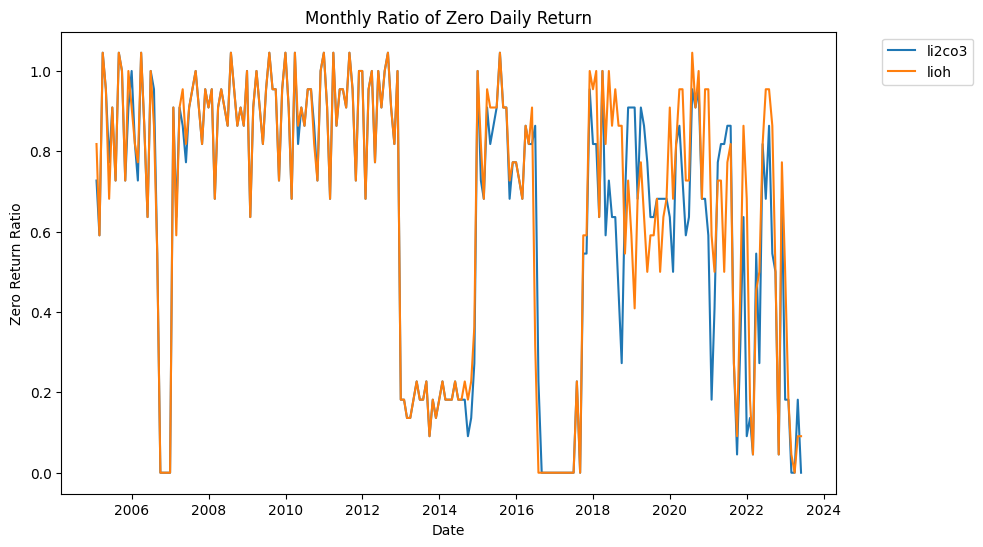

In [154]:
def zeros(df, freq): # Get daily return and zeros, freq = 'M' for monthly end zeros, 'A' for yearly end zeros

    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
    df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    df['Zeros'] = (df['Daily_Return'] == 0).astype(int)

    if freq == 'M':
        z = df['Zeros'].resample(freq).sum() / 22
    else:
        z = df['Zeros'].resample(freq).sum() / 252
    # z = df['Zeros'].resample(freq).sum() / df[freq].resample('M').size()
    return z.to_frame()


# Full range prices considered in zeros
y_zeros_m = {df: zeros(y_full[df], 'M') for df in y_full}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in y_zeros_m:
    plt.plot(y_zeros_m[df], label = df)

plt.title('Monthly Ratio of Zero Daily Return')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('./y_plot/zero_ratios.png')

### Yearly Zeros Table

In [155]:
# y_zeros_y = {df: zeros(y_full[df],'A') for df in y_full}

# zeros_table = pd.DataFrame(index = y_zeros_y['li2co3'].index)
# for df in y_zeros_y:
#     zeros_table = pd.merge(zeros_table, y_zeros_y[df].loc[:,'Zeros'], how='left', left_index=True, right_index=True, suffixes=(None,f'_{df}'))
# zeros_table.rename(columns = {'Zeros':'Zeros_li2co3'}, inplace=True)
# display(zeros_table)

## Benchmark Weekly Return

In [156]:
def get_weekly(df, d): # d: 0-4 for Mon-Fri
    w = df.copy()
    w.rename(columns = {w.columns[0]: 'Price'}, inplace = True)

    # Select one weekday
    w = w[w.index.dayofweek == d]

    w['Prior_Date'] = w.index - datetime.timedelta(days=7) # Get date one week ago
    w['Prior_Price'] = w['Prior_Date'].apply(lambda i: w.loc[i,'Price'] if i in w.index else np.NaN) # Get price one week ago
    w['Weekly_Return'] = np.log(w.Price) - np.log(w.Prior_Price) # Weekly return
    w['Weekly_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)

    w = w.drop(columns = ['Prior_Date','Prior_Price'])
    return w

def return_dict():
    for i in range(5):
        for df in y_full:
            globals()[f'y_{i}_full'] = {df: get_weekly(y_full[df],i) for df in y_full}
        for df in y_2021:
            globals()[f'y_{i}_2021'] = {df: get_weekly(y_2021[df],i) for df in y_2021}

return_dict()

## Returns Unsmoothing AR model

In [157]:
# 2017-09-08 to 2023-05-22

# Augmented Dickey-Fuller Test and Autoregressive Model
# True and Observation weekly returns are stored in y_{i}_ar

def unsmoothing(dict_suffix = 'full'): # default 'full', or '2021'
    for i in range(5):
        globals()[f'y_{i}_unsmooth_{dict_suffix}'] = {}
        
        temp1 = globals()[f'y_{i}_{dict_suffix}']

        for df in temp1.keys():
            adf = adfuller(temp1[df].Weekly_Return.dropna(), maxlag = 1)
            dayofweek = calendar.day_abbr[i]
            print(f'{dayofweek}-to-{dayofweek} {df} \t{dict_suffix}\t test statistics: {round(adf[0],4)} \t p-value: {adf[1]:.4e}')

            temp2 = globals()[f'y_{i}_{dict_suffix}'][df].Weekly_Return.copy()
            temp2.dropna(inplace = True)

            ar_model = AutoReg(endog=temp2, lags=1).fit()
            pred_ar = ar_model.predict(start=1, end=len(temp2))
            pred_ar.index = temp2.index

            ma_model1 = ARIMA(endog=temp2, order=(0, 0, 1)).fit()
            pred_ma1 = ma_model1.predict(start=1, end=len(temp2))
            pred_ma1.index = temp2.index

            ma_model2 = ARIMA(endog=temp2, order=(0, 0, 2)).fit()
            pred_ma2 = ma_model2.predict(start=1, end=len(temp2))
            pred_ma2.index = temp2.index

            ma_model3 = ARIMA(endog=temp2, order=(0, 0, 3)).fit()
            pred_ma3 = ma_model3.predict(start=1, end=len(temp2))
            pred_ma3.index = temp2.index

            globals()[f'y_{i}_unsmooth_{dict_suffix}'][df] = pd.concat([temp2, pred_ar, pred_ma1, pred_ma2, pred_ma3 ], axis = 1, ignore_index=True)

            globals()[f'y_{i}_unsmooth_{dict_suffix}'][df].columns = ['r_obs','r_true_ar','r_true_ma1', 'r_true_ma2', 'r_true_ma3'] 
    print()

unsmoothing()
unsmoothing('2021')

Mon-to-Mon li2co3 	full	 test statistics: -14.479 	 p-value: 6.4188e-27


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: 

Mon-to-Mon lioh 	full	 test statistics: -13.0843 	 p-value: 1.8437e-24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Tue-to-Tue li2co3 	full	 test statistics: -14.8118 	 p-value: 2.0248e-27


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning

Tue-to-Tue lioh 	full	 test statistics: -12.901 	 p-value: 4.2491e-24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Wed-to-Wed li2co3 	full	 test statistics: -15.0075 	 p-value: 1.0673e-27


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Wed-to-Wed lioh 	full	 test statistics: -13.3309 	 p-value: 6.1869e-25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Thu-to-Thu li2co3 	full	 test statistics: -14.0405 	 p-value: 3.3098e-26


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Thu-to-Thu lioh 	full	 test statistics: -11.0056 	 p-value: 6.5175e-20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Fri-to-Fri li2co3 	full	 test statistics: -10.8981 	 p-value: 1.1779e-19


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Fri-to-Fri lioh 	full	 test statistics: -11.926 	 p-value: 4.9046e-22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning


Mon-to-Mon li2co3 	2021	 test statistics: -2.4656 	 p-value: 1.2408e-01
Mon-to-Mon lioh 	2021	 test statistics: -4.48 	 p-value: 2.1364e-04


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been prov

Tue-to-Tue li2co3 	2021	 test statistics: -2.7756 	 p-value: 6.1848e-02
Tue-to-Tue lioh 	2021	 test statistics: -4.7477 	 p-value: 6.8392e-05


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Wed-to-Wed li2co3 	2021	 test statistics: -2.6589 	 p-value: 8.1417e-02
Wed-to-Wed lioh 	2021	 test statistics: -5.0448 	 p-value: 1.8078e-05


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning

Thu-to-Thu li2co3 	2021	 test statistics: -1.9034 	 p-value: 3.3045e-01
Thu-to-Thu lioh 	2021	 test statistics: -2.6857 	 p-value: 7.6538e-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

Fri-to-Fri li2co3 	2021	 test statistics: -1.7516 	 p-value: 4.0475e-01
Fri-to-Fri lioh 	2021	 test statistics: -3.7292 	 p-value: 3.7213e-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

### Check true vs obs (Graph)

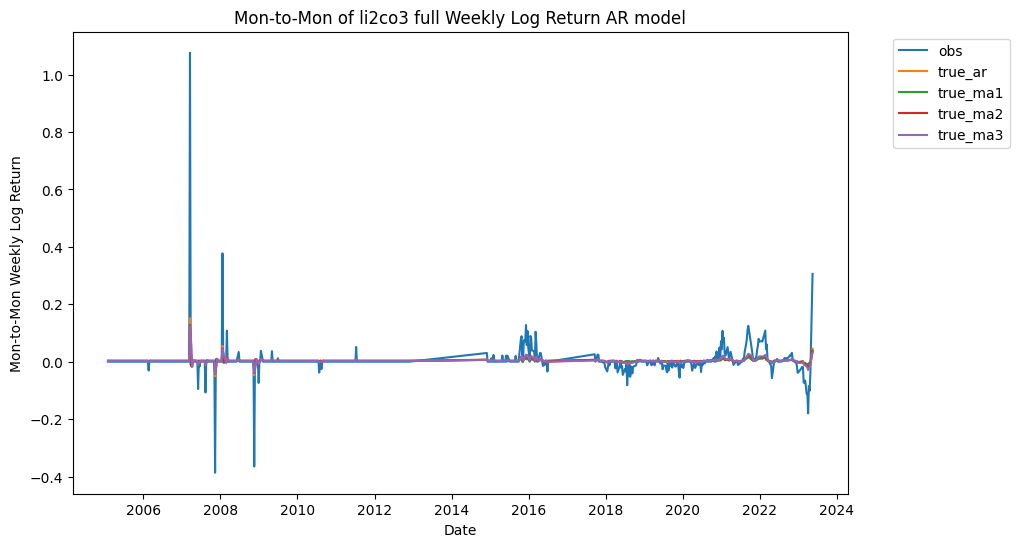

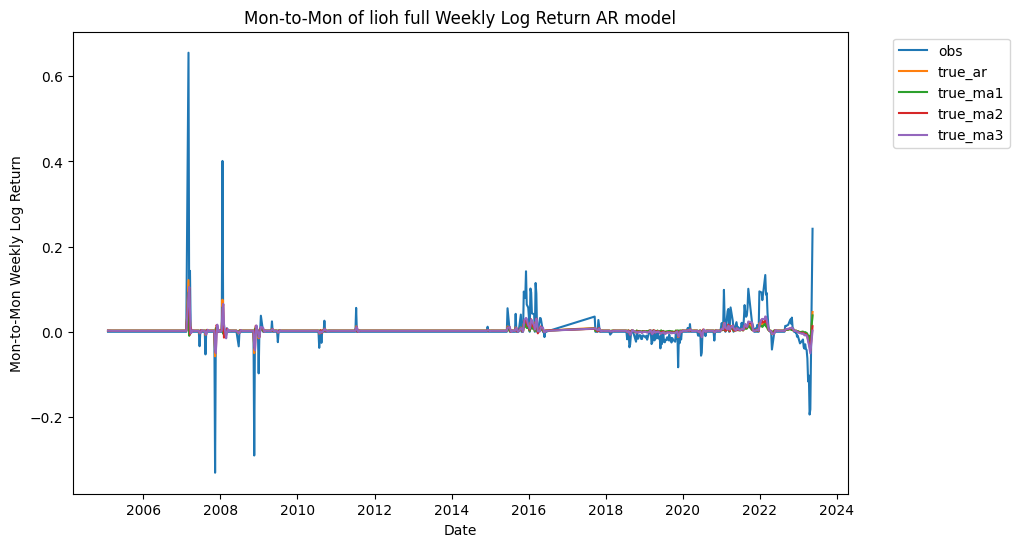

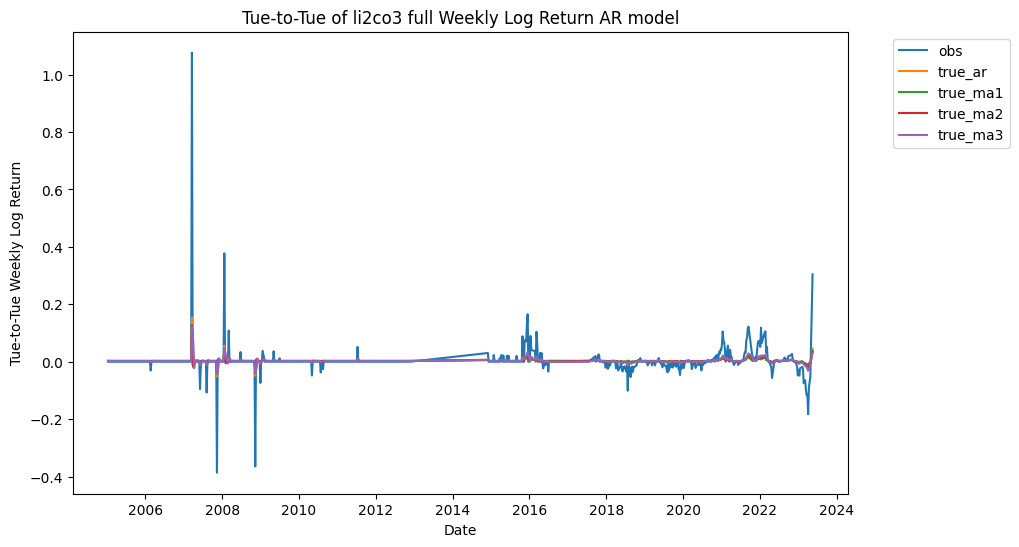

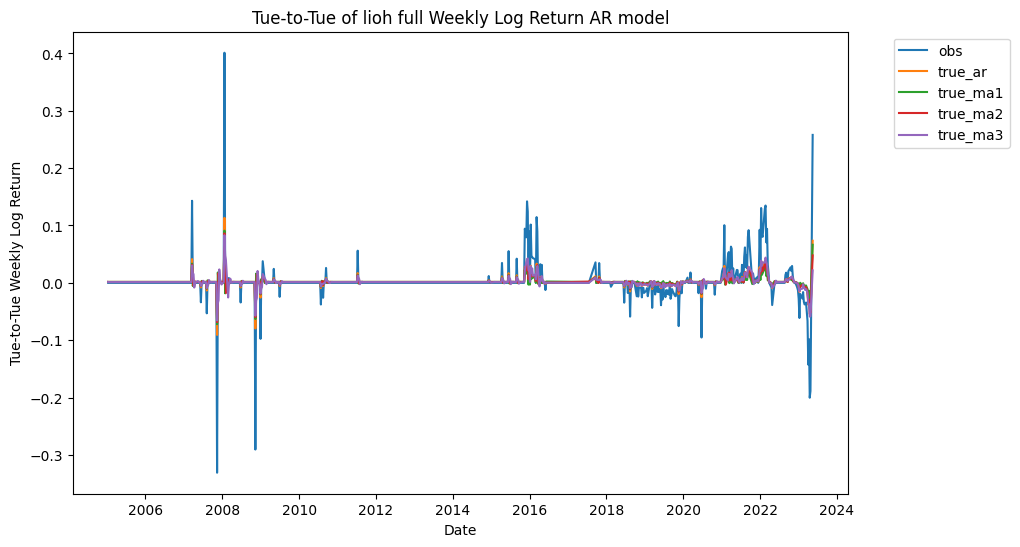

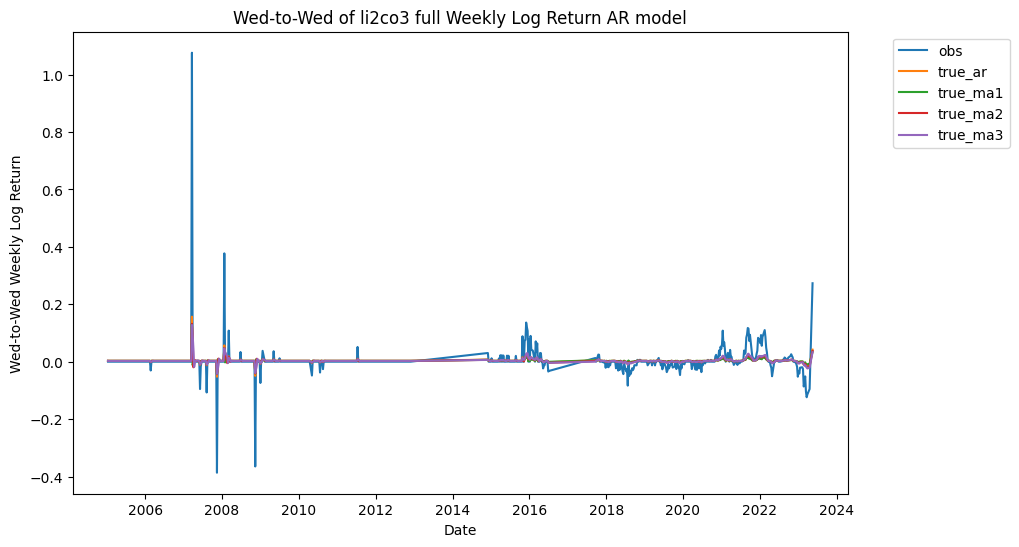

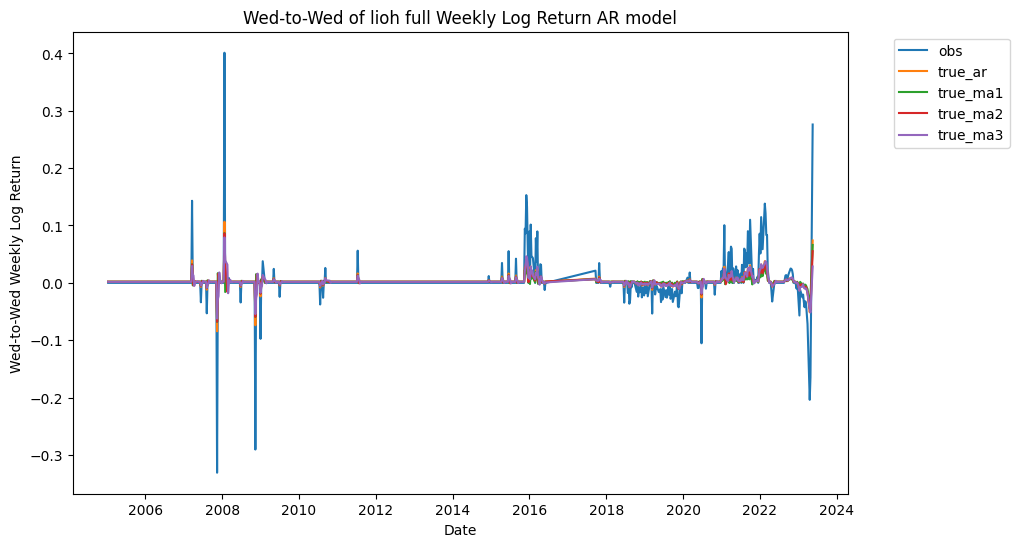

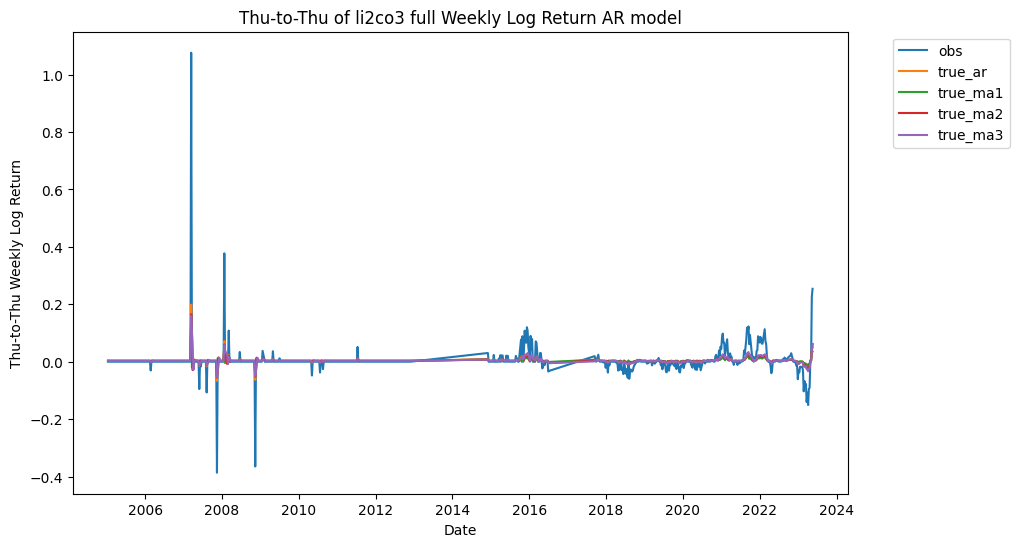

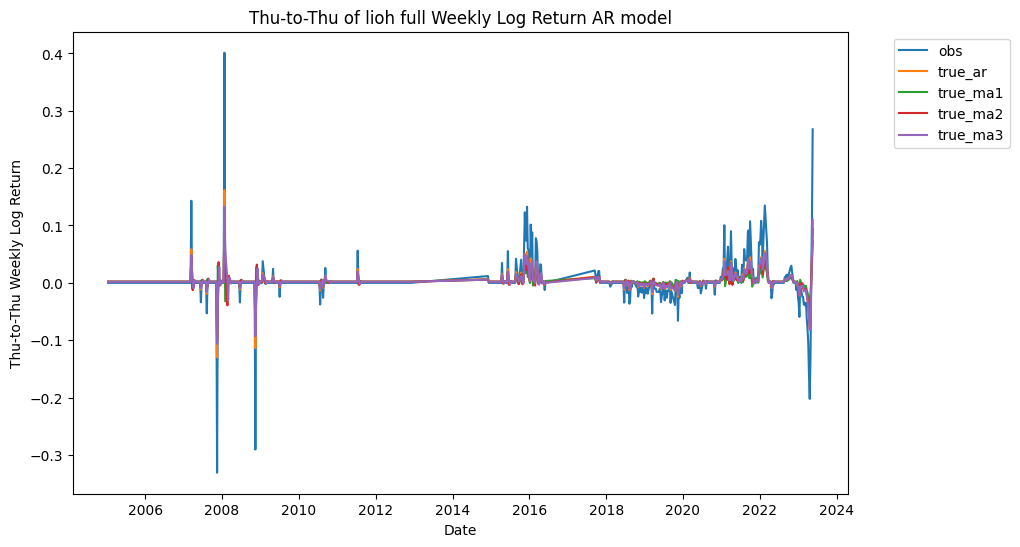

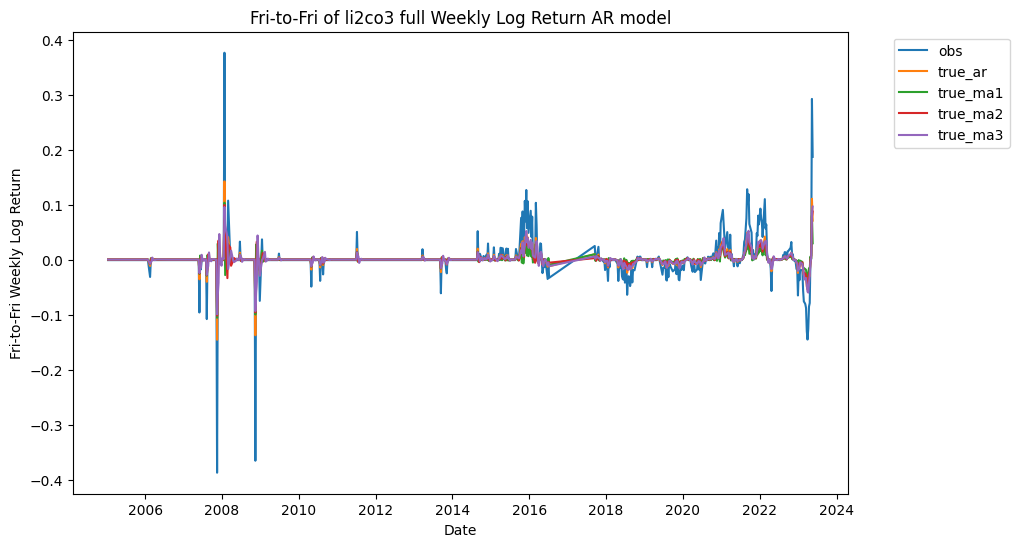

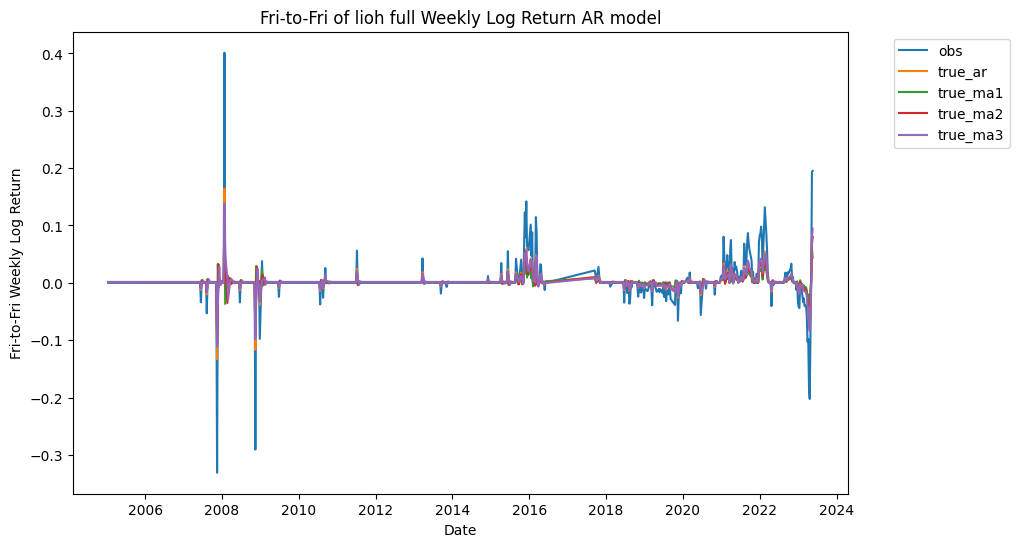

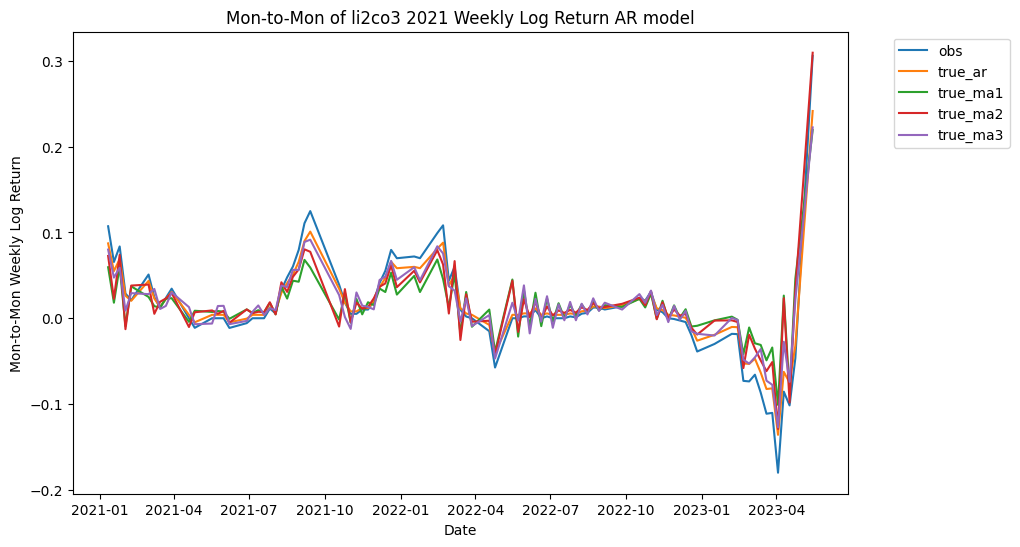

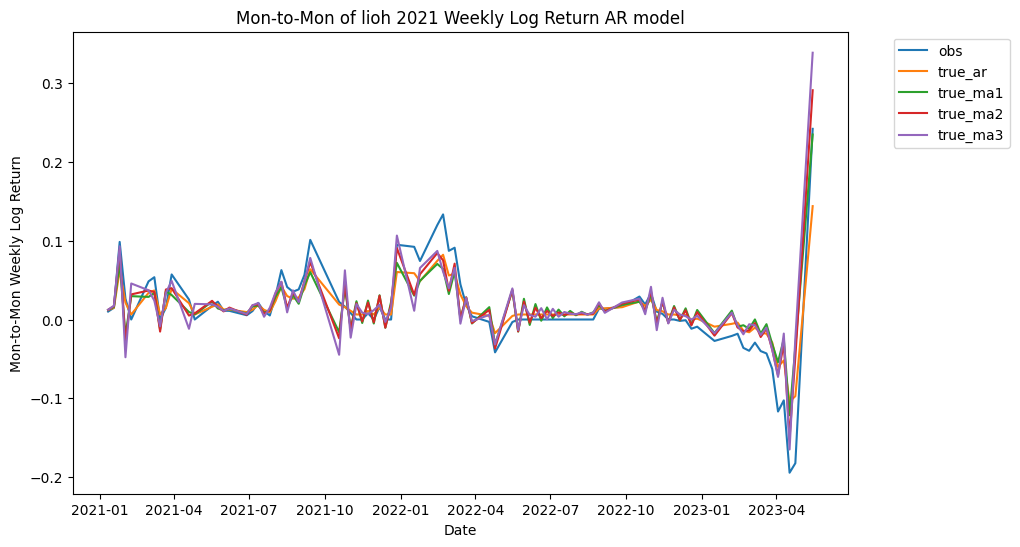

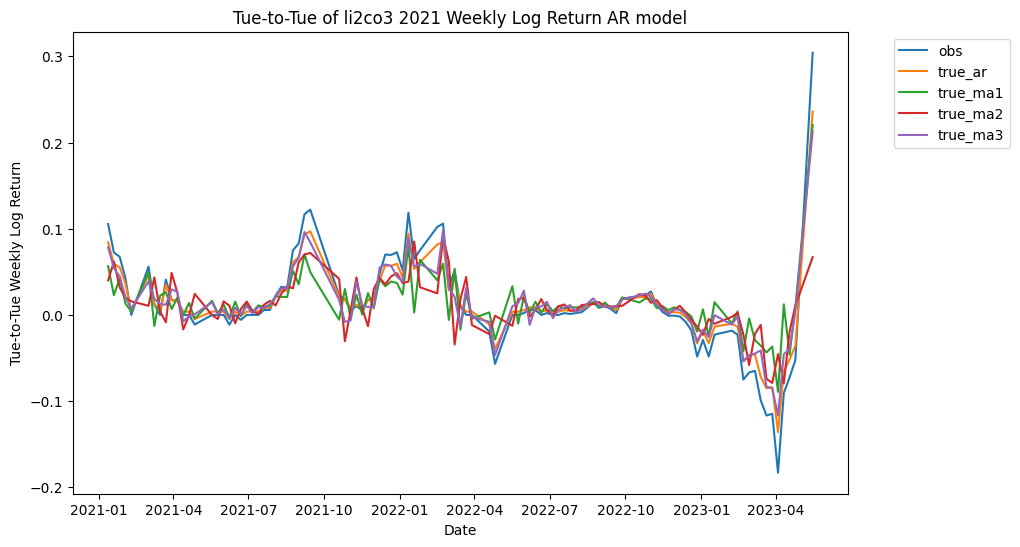

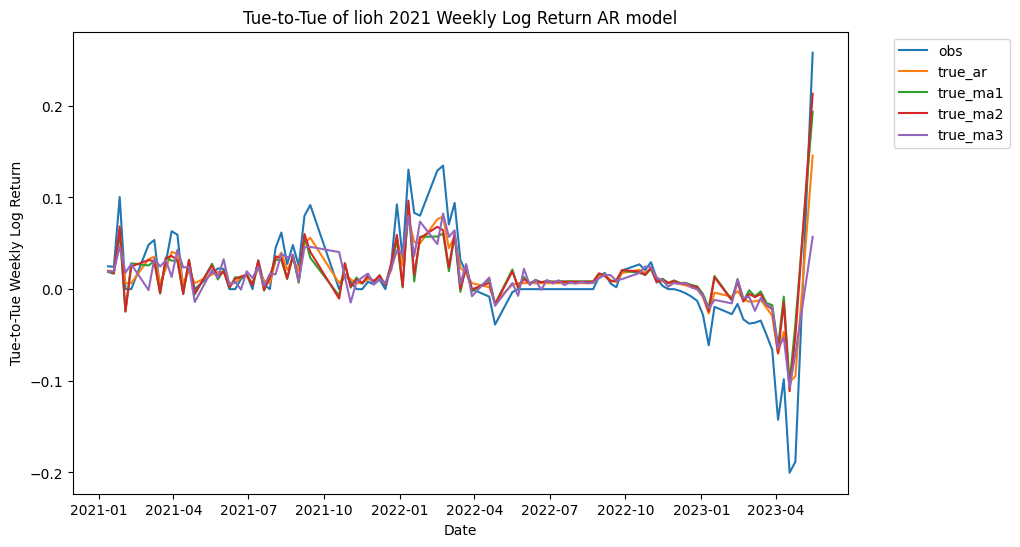

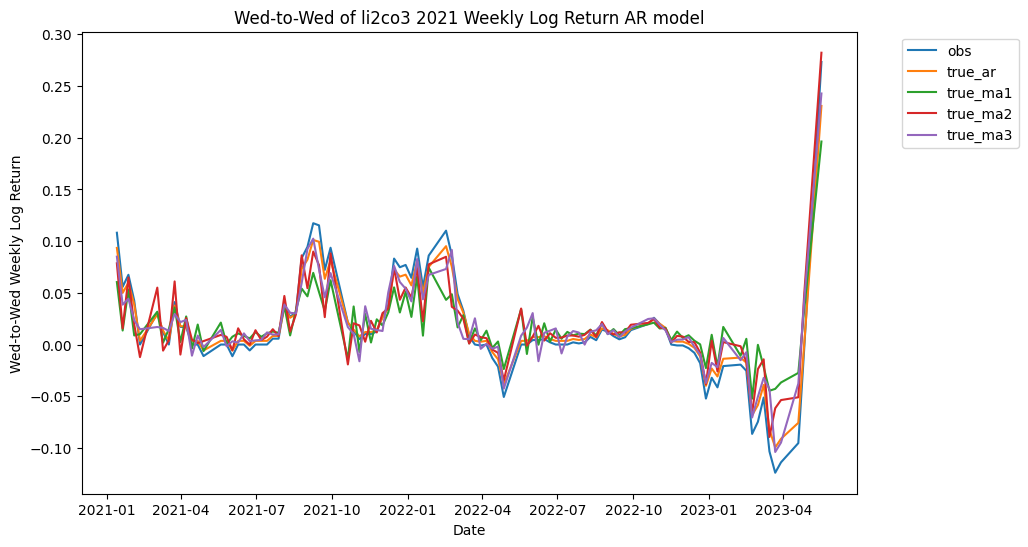

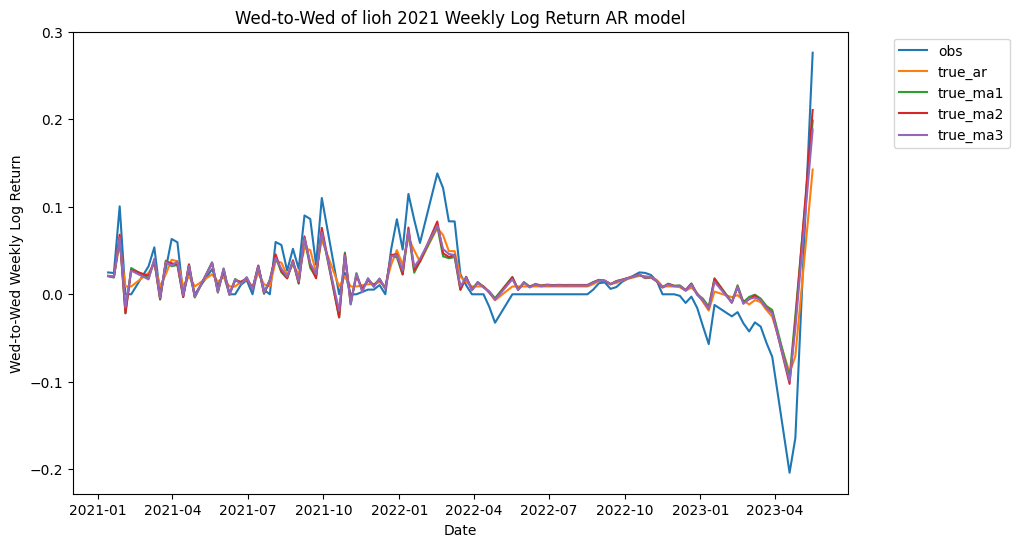

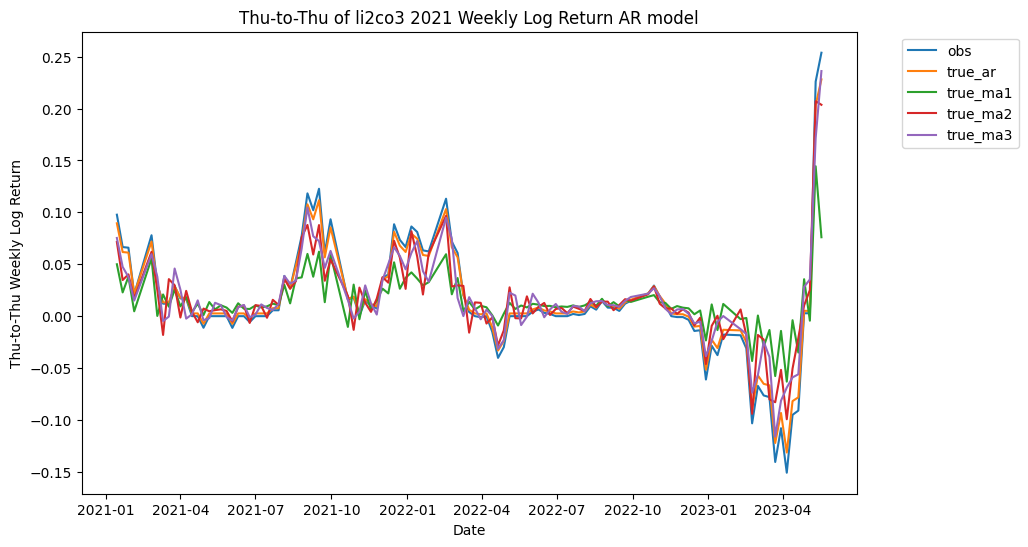

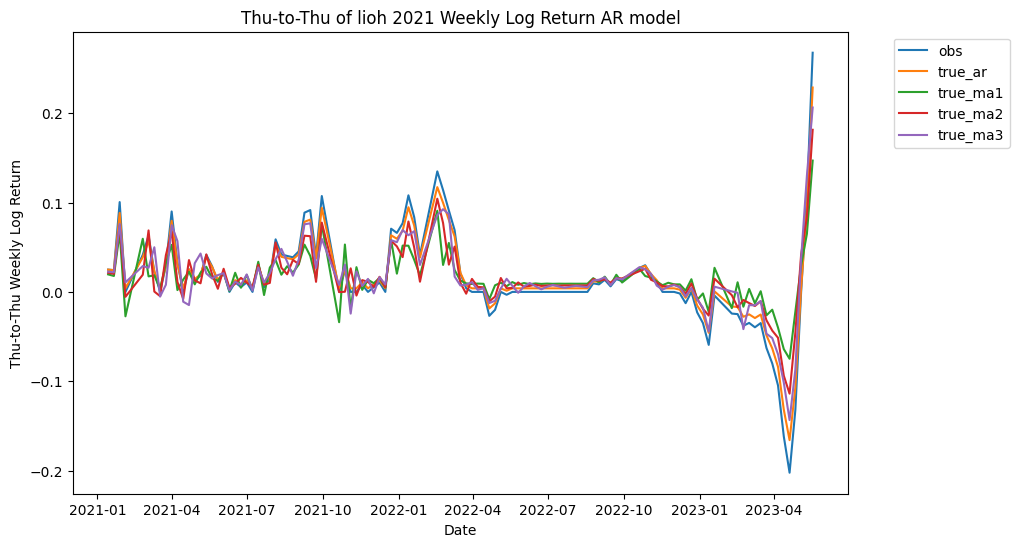

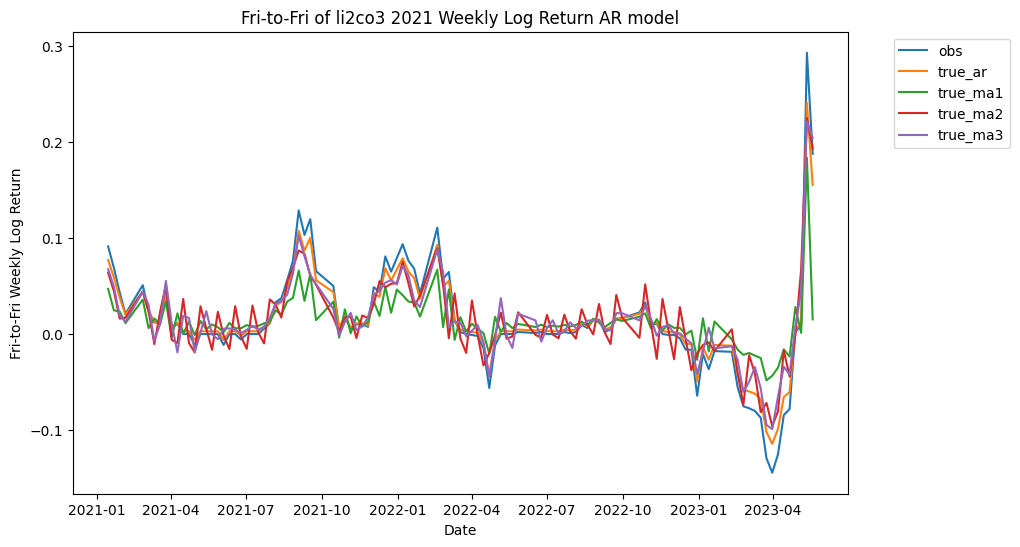

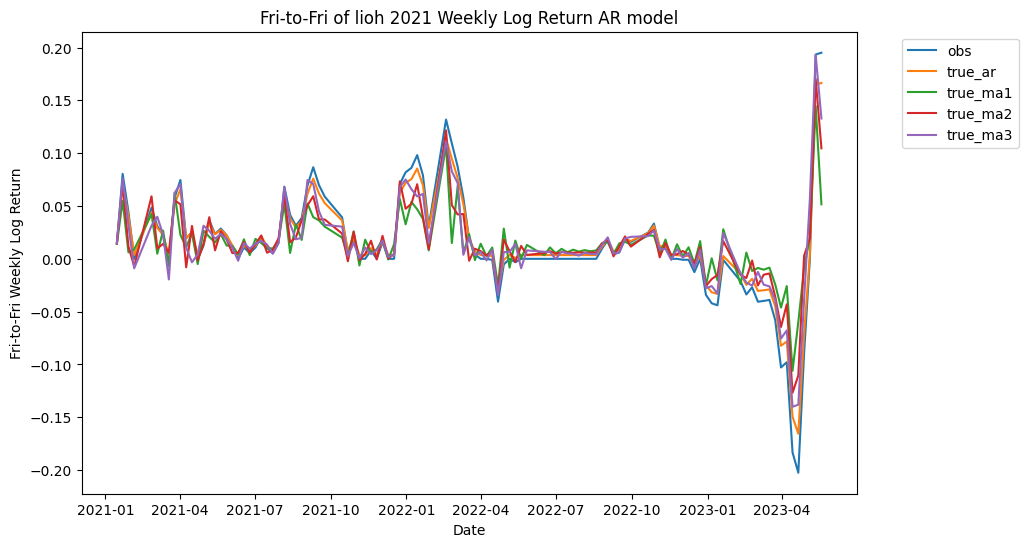

In [158]:
def plot_true_obs(dict_suffix = 'full'): # default 'full', or '2021'
    for i in range(5):
        temp = globals()[f'y_{i}_unsmooth_{dict_suffix}']
        for df in temp.keys():
            fig = plt.figure(figsize = (10,6))
            
            plt.plot(temp[df]['r_obs'], label = 'obs')
            plt.plot(temp[df]['r_true_ar'], label = 'true_ar')
            plt.plot(temp[df]['r_true_ma1'], label = 'true_ma1')
            plt.plot(temp[df]['r_true_ma2'], label = 'true_ma2')
            plt.plot(temp[df]['r_true_ma3'], label = 'true_ma3')


            plt.title(f'{calendar.day_abbr[i]}-to-{calendar.day_abbr[i]} of {df} {dict_suffix} Weekly Log Return AR model')
            plt.xlabel('Date')
            plt.ylabel(f'{calendar.day_abbr[i]}-to-{calendar.day_abbr[i]} Weekly Log Return')
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.savefig(f'./y_plot/return_{df}_{i}_{dict_suffix}.png')

plot_true_obs()
plot_true_obs('2021')


In [159]:
# df to csv
for i in range(5):
    for dict_suffix in ['full','2021']:
        for df in ['li2co3','lioh']:
            globals()[f'y_{i}_unsmooth_{dict_suffix}'][df].to_csv(f'./Data/unsmoothed_y/{df}_{i}_{dict_suffix}.csv')

### Check true vs obs (Liquidity / Zeros) AR

In [160]:
def check_zeros_ar(dict_suffix = 'full'): # full or 2021
    for i in range(5):
        temp = globals()[f'y_{i}_unsmooth_{dict_suffix}']
        for df in temp.keys():
            fig = plt.figure(figsize = (10,6))
            
            temp[df]['Zeros_obs'] = (temp[df]['r_obs'] == 0).astype(int)
            temp[df]['Zeros_true_ar'] = (temp[df]['r_true_ar'] == 0).astype(int)
            temp[df]['Zeros_true_ma1'] = (temp[df]['r_true_ma1'] == 0).astype(int)
            temp[df]['Zeros_true_ma2'] = (temp[df]['r_true_ma2'] == 0).astype(int)
            temp[df]['Zeros_true_ma3'] = (temp[df]['r_true_ma3'] == 0).astype(int)

            z_obs = temp[df]['Zeros_obs'].resample('M').sum() / 22
            z_true_ar = temp[df]['Zeros_true_ar'].resample('M').sum() / 22
            z_true_ma1 = temp[df]['Zeros_true_ma1'].resample('M').sum() / 22
            z_true_ma2 = temp[df]['Zeros_true_ma2'].resample('M').sum() / 22
            z_true_ma3 = temp[df]['Zeros_true_ma3'].resample('M').sum() / 22


            plt.plot(z_obs, label = 'obs')
            plt.plot(z_true_ar, label = 'true_ar')
            plt.plot(z_true_ma1, label = 'true_ma1')
            plt.plot(z_true_ma2, label = 'true_ma2')
            plt.plot(z_true_ma3, label = 'true_ma3')


            plt.title(f'{calendar.day_abbr[i]}-to-{calendar.day_abbr[i]} of {df} {dict_suffix} Monthly Zero Return Ratio AR model')
            plt.xlabel('Date')
            plt.ylabel('Zero Return Ratio')
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()

# check_zeros_ar()
# check_zeros_ar('2021')

Now we have dictionaries the following dataframes, each with observed data, unsmoothed data with AR, and unsmoothed data with MA: </br>(i ranged from 0 to 4)

1. y\_{i}\_unsmooth\_full </br>
2. y\_{i}\_unsmooth\_2021

### Y Mean, Standard Deviation

In [170]:
def mean_std(dict_suffix = 'full'): # dict_suffix: default full / 2021
    mean_std = []

    r_cols = globals()[f'y_0_unsmooth_{dict_suffix}']['li2co3'].columns.to_list()
    r_cols = ['y'] + [s + ' mean' for s in r_cols] + [s + ' std' for s in r_cols]

    for i in range (5):
        for df in ['li2co3','lioh']:

            idx = [f'{df} {calendar.day_abbr[i]}']

            temp = globals()[f'y_{i}_unsmooth_{dict_suffix}']

            mean = round(temp[df].mean(),4).to_list()
            std = round(temp[df].std(),4).to_list()
            
            mean_std.append(idx + mean + std)

    y_mean_std = pd.DataFrame(mean_std, columns = r_cols)
    y_mean_std = y_mean_std.set_index('y')
    y_mean_std.to_csv(f'./y_mean_std_{dict_suffix}.csv')

mean_std()
mean_std('2021')

### Y Autocorrelation

1. y\_{i}\_unsmooth\_full </br>
2. y\_{i}\_unsmooth\_2021

/var/folders/fb/7yr8_8z17z95nw0_h9q4wn2r0000gn/T/ipykernel_48363/412837818.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(10,5))


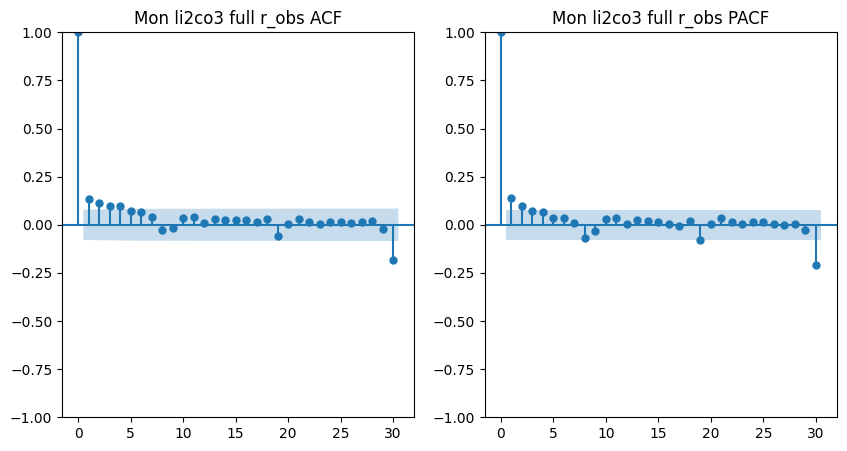

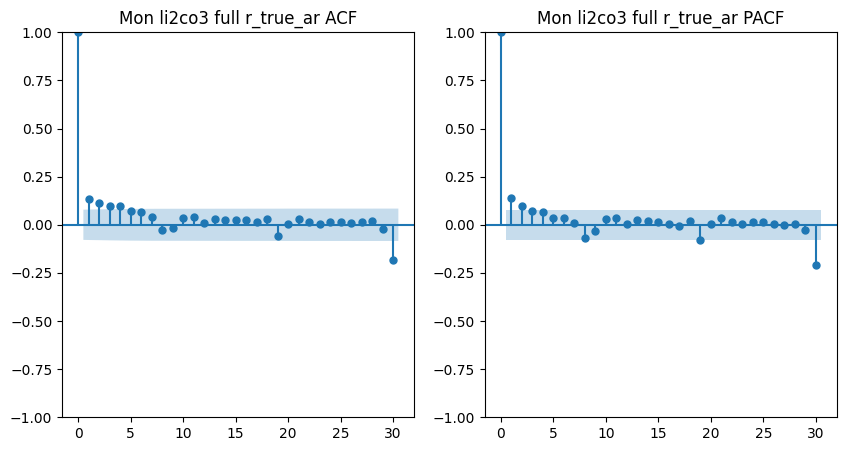

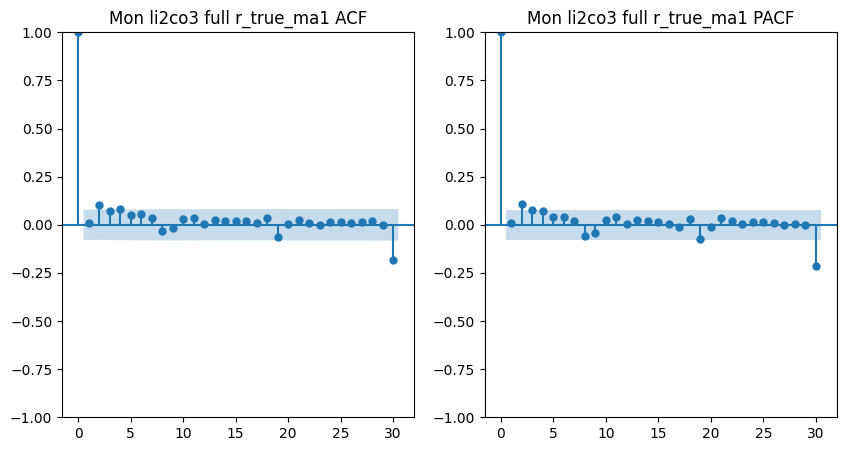

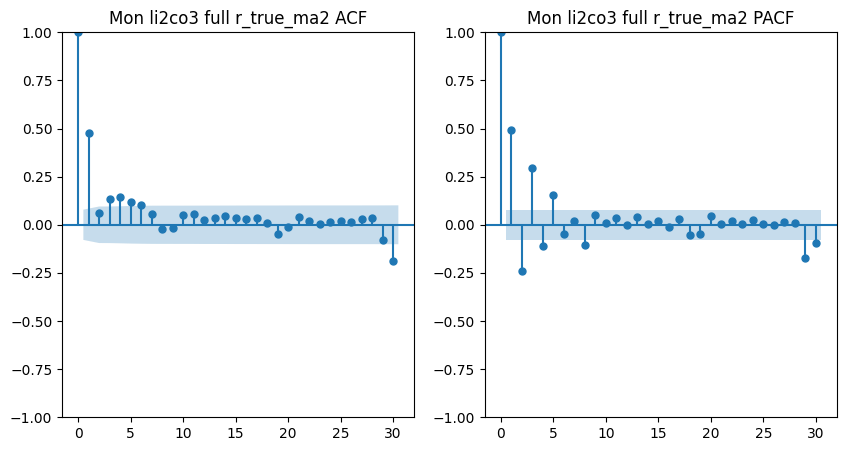

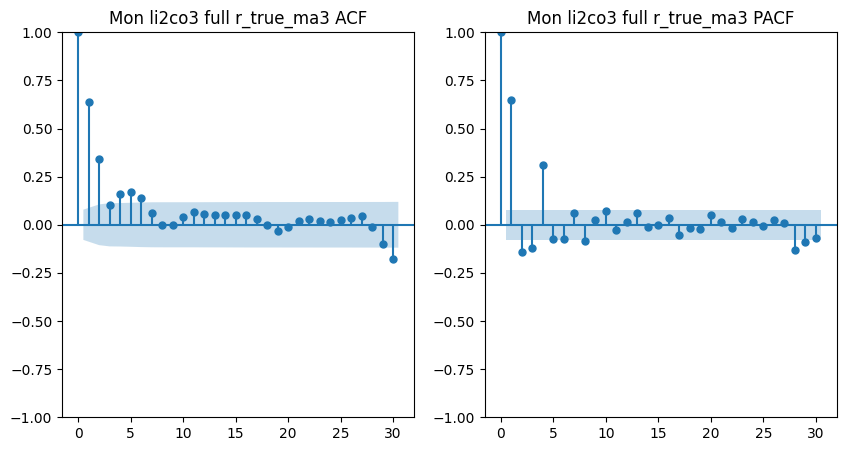

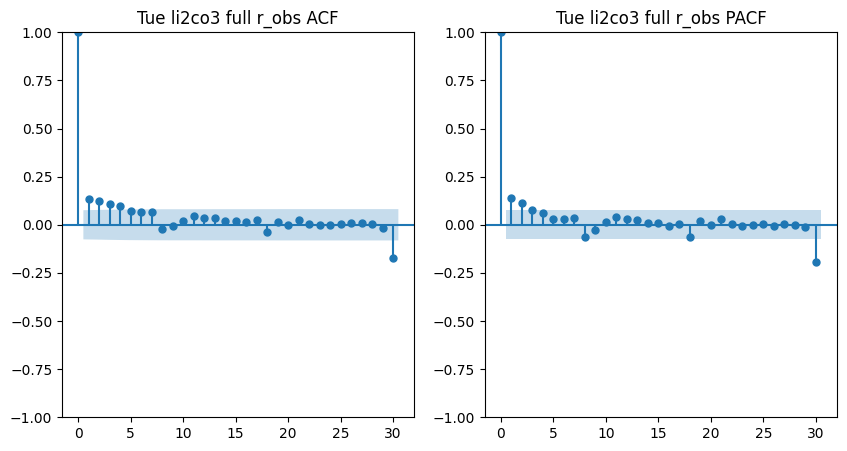

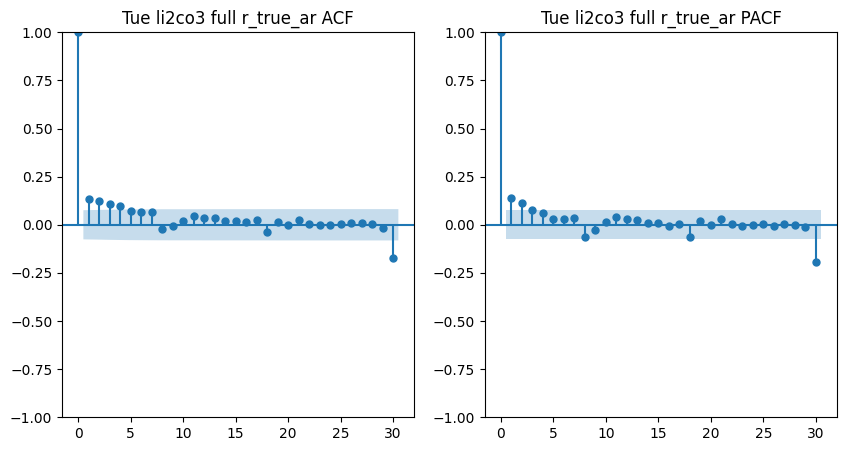

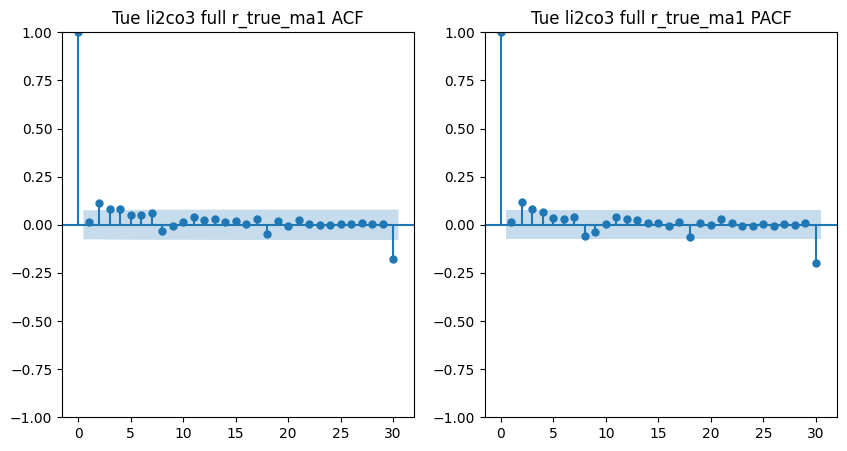

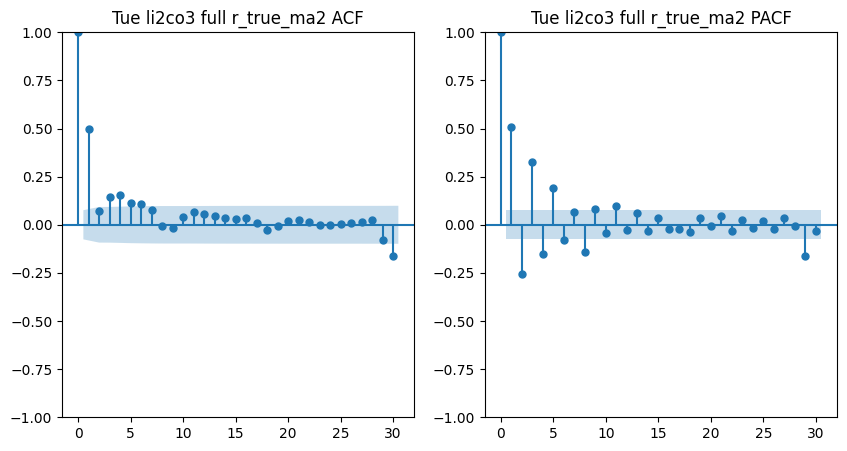

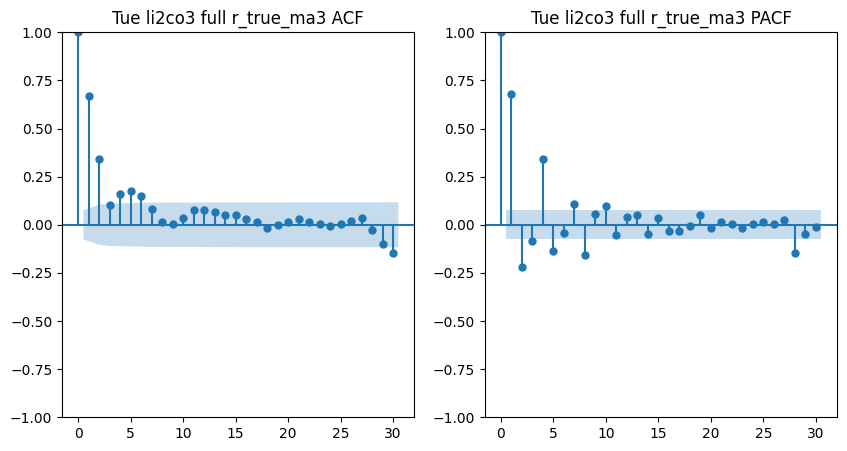

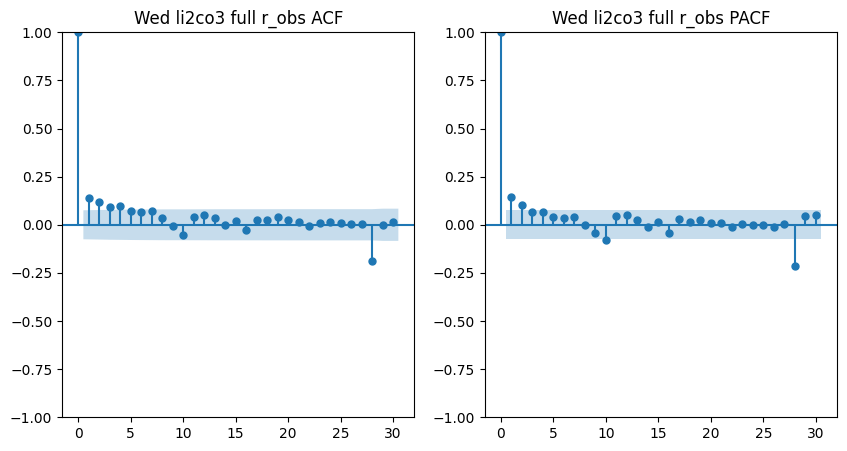

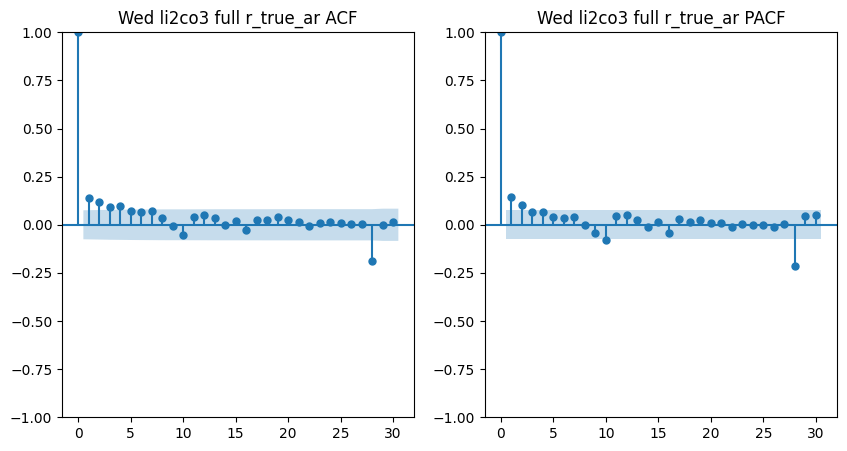

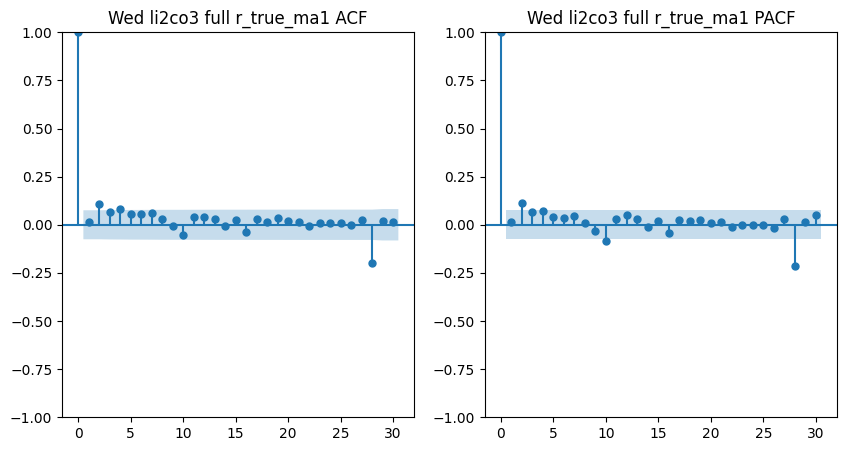

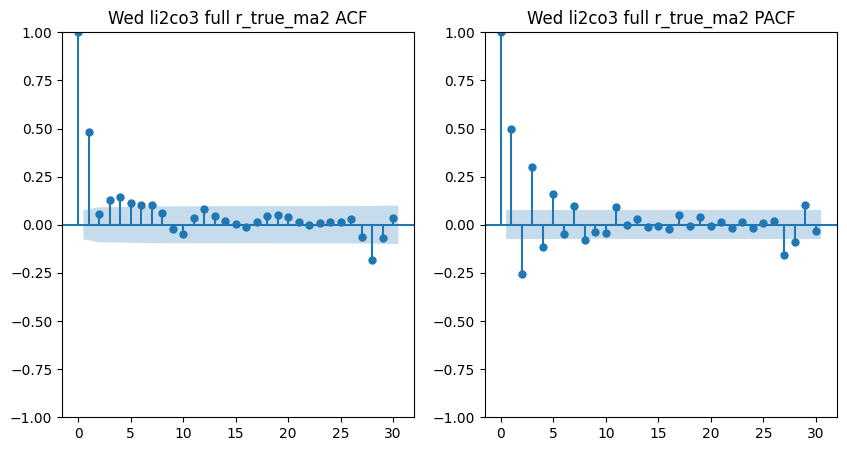

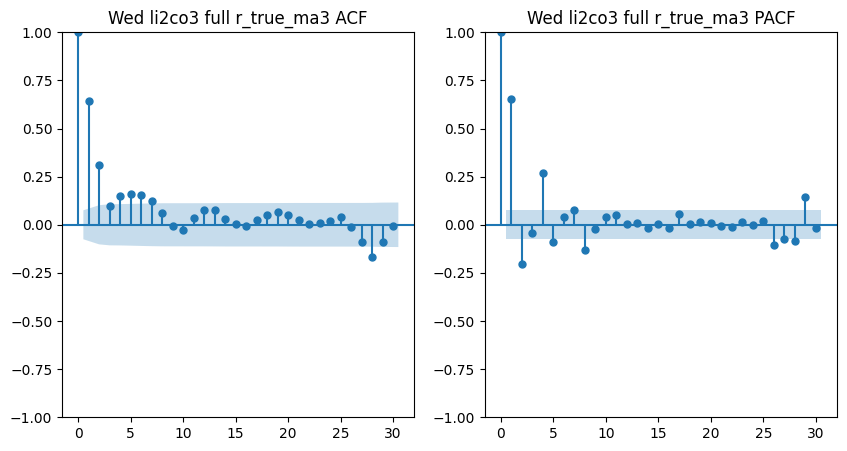

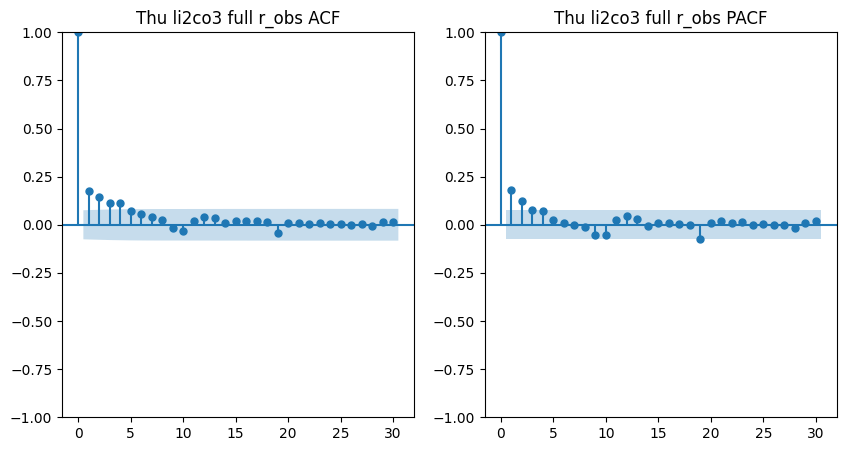

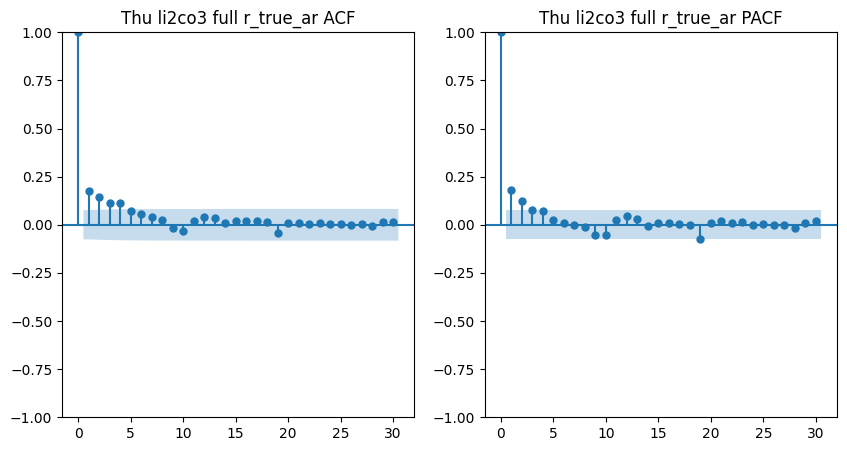

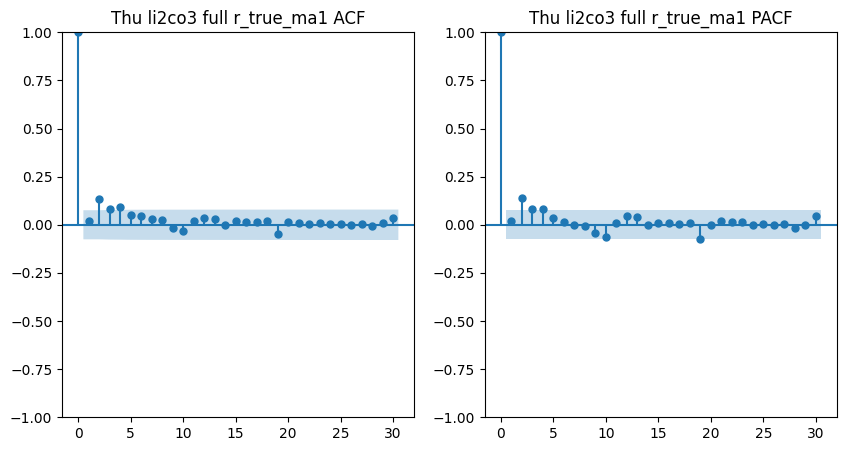

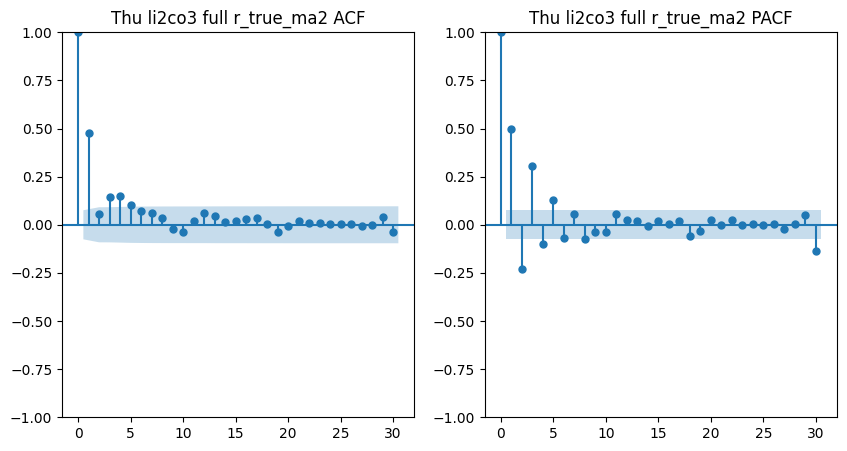

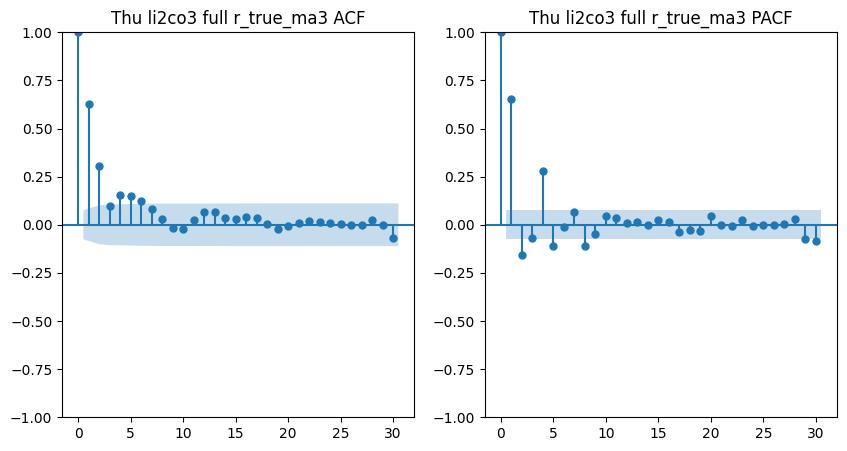

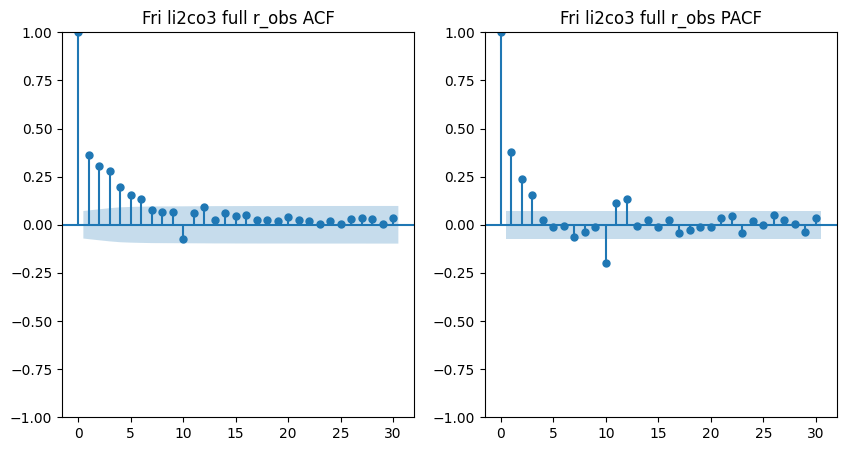

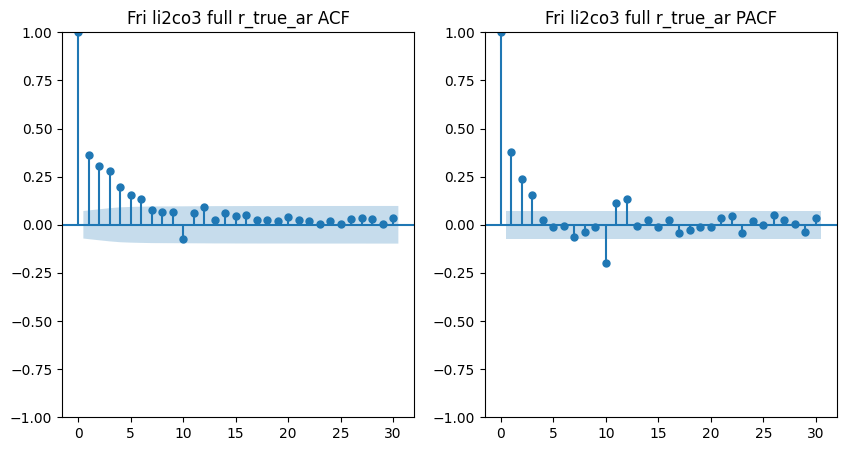

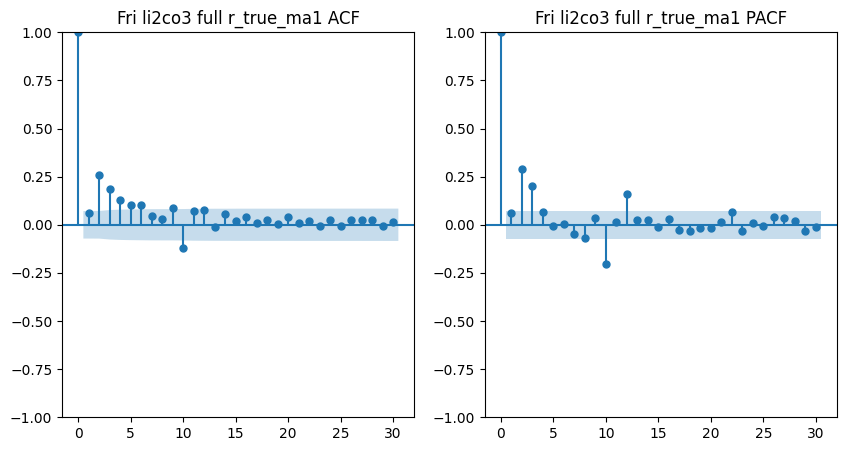

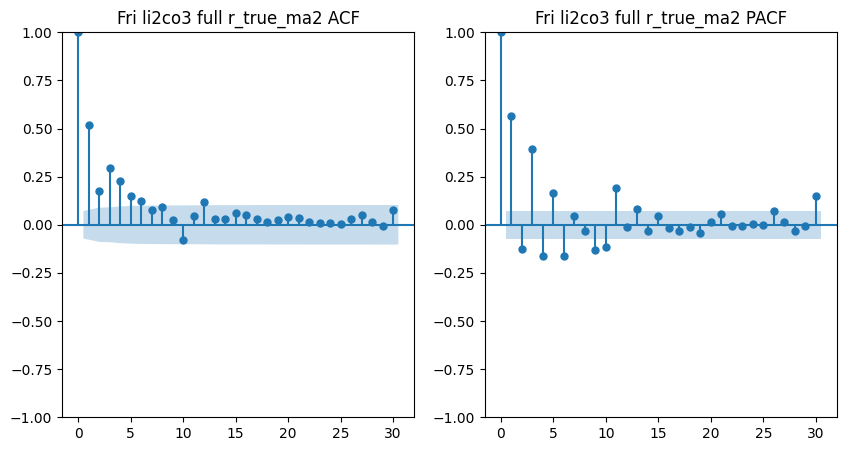

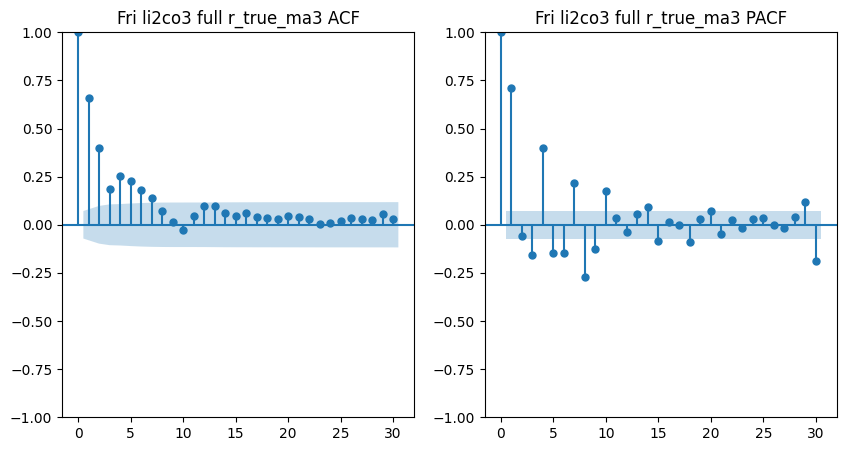

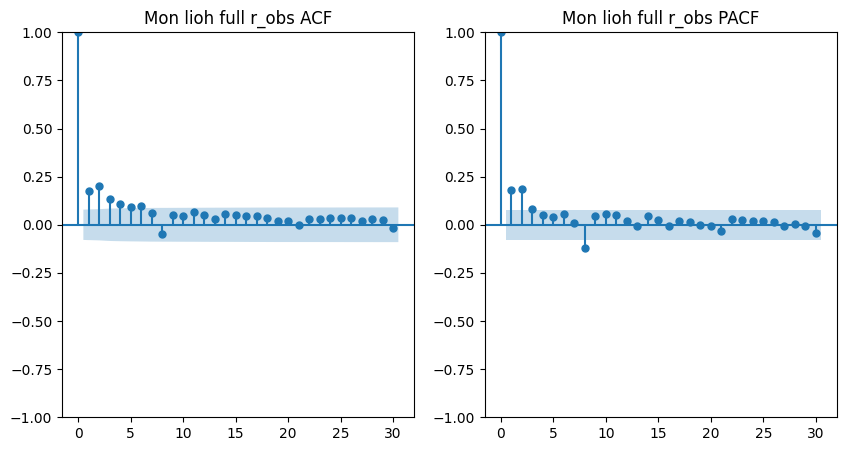

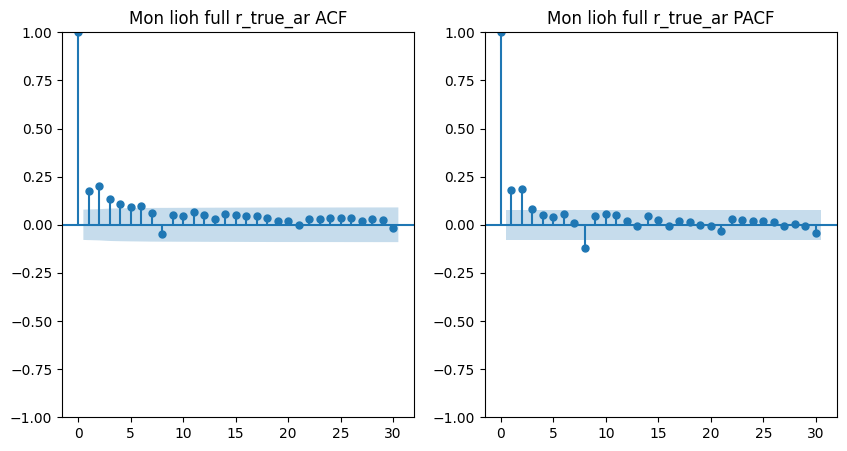

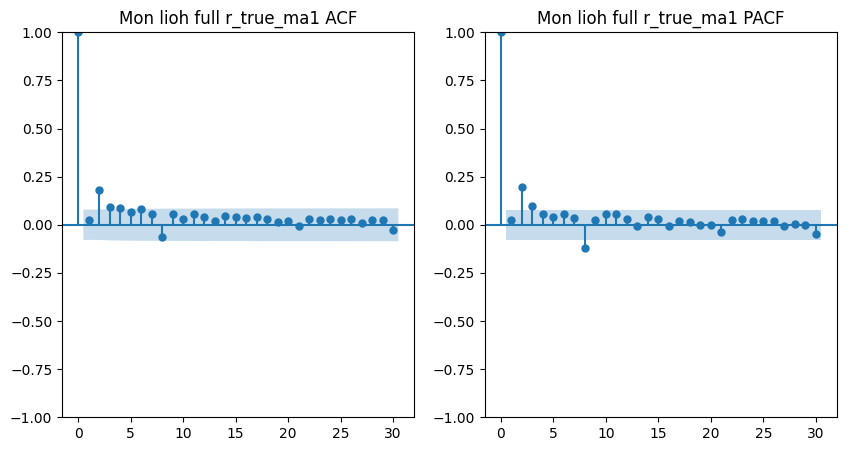

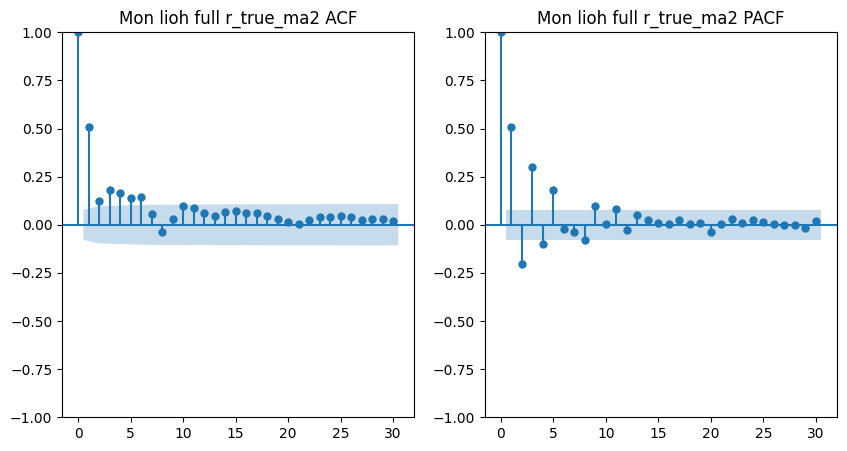

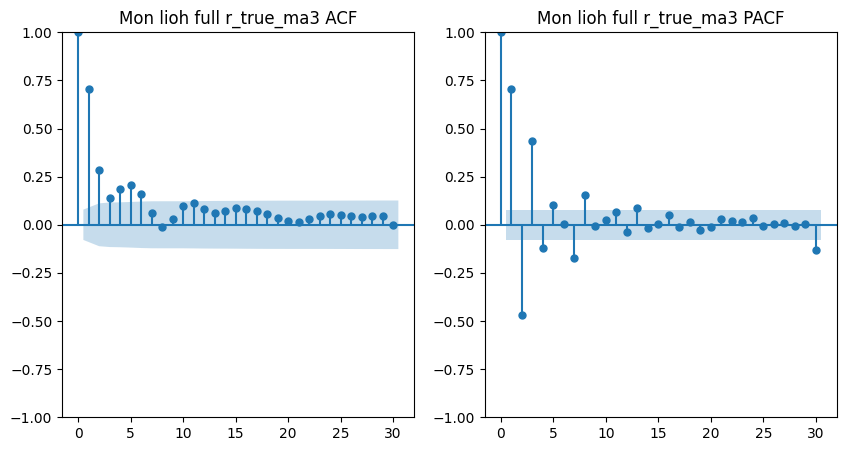

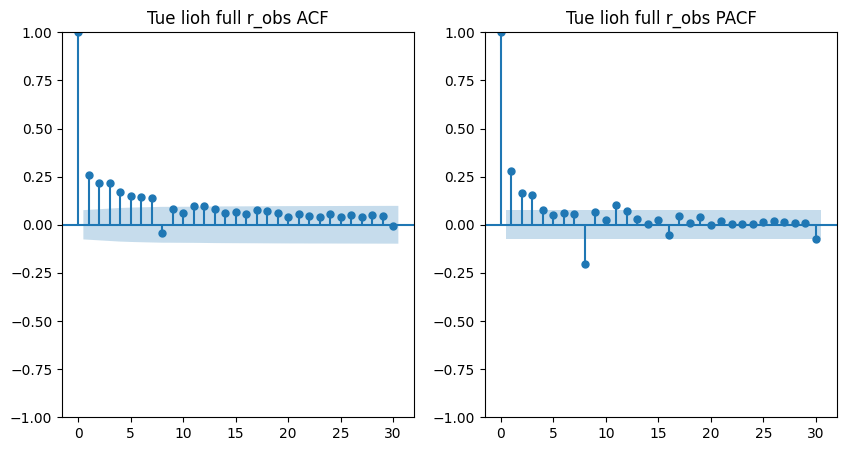

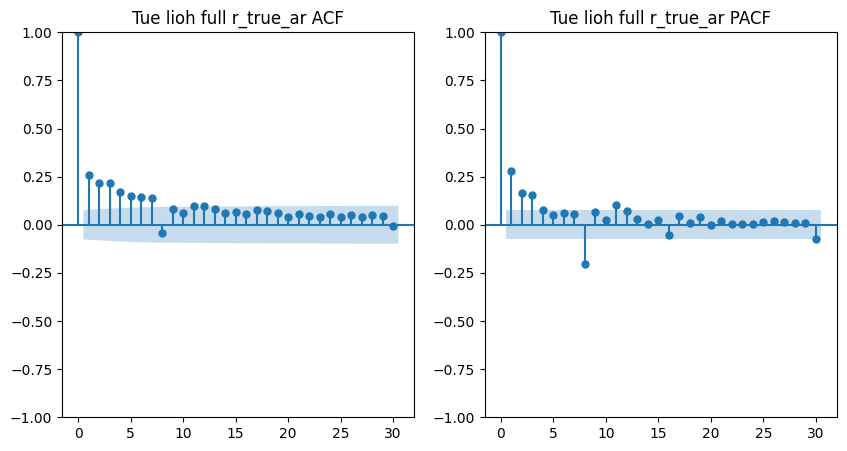

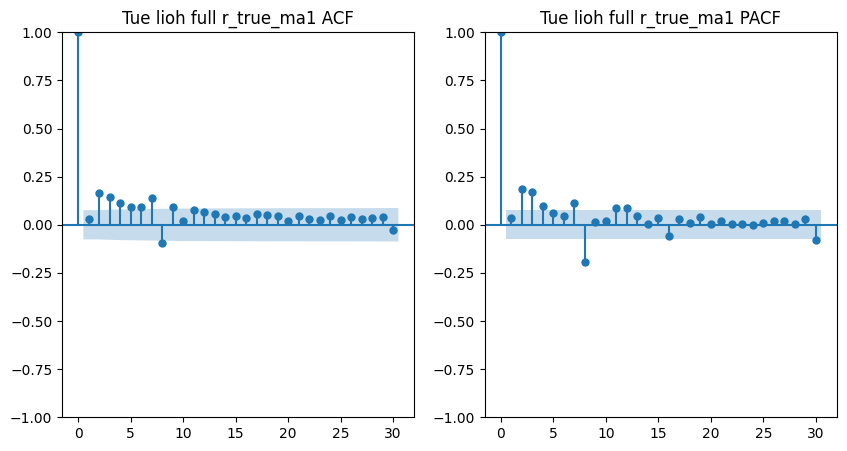

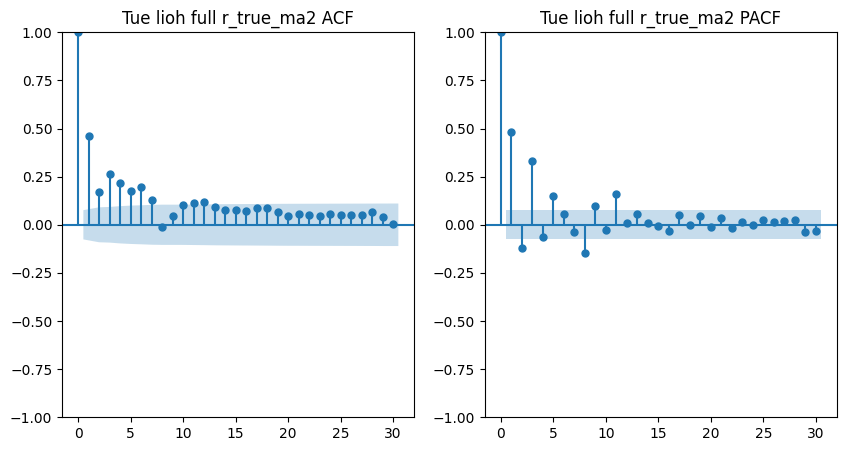

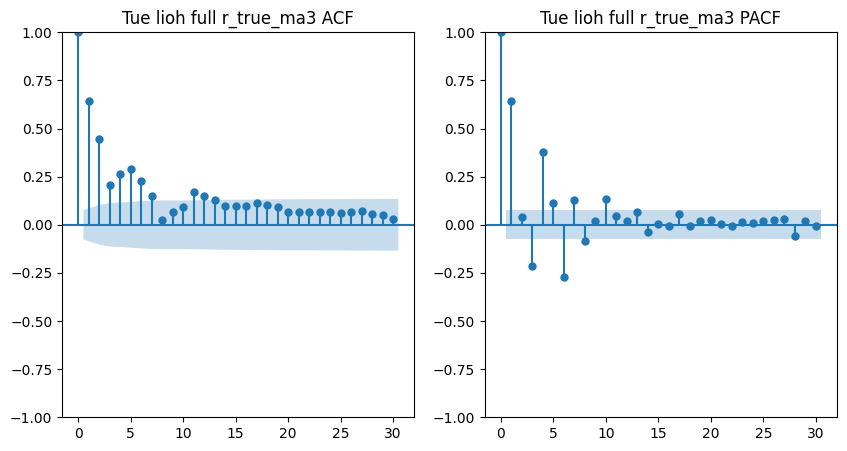

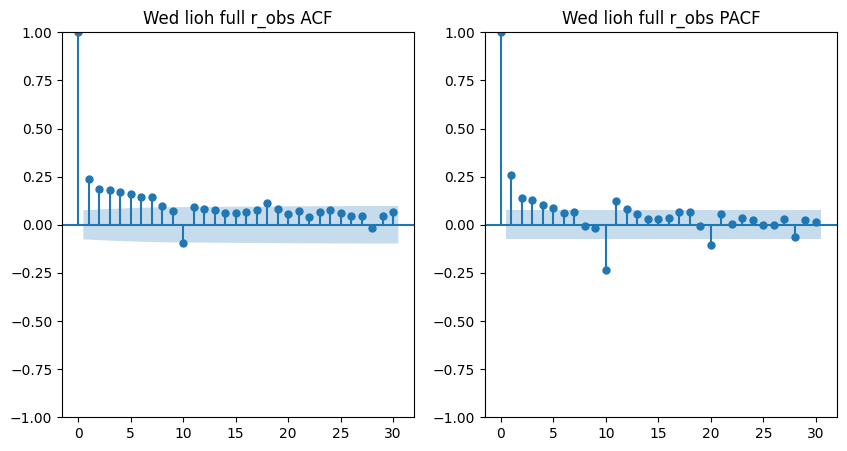

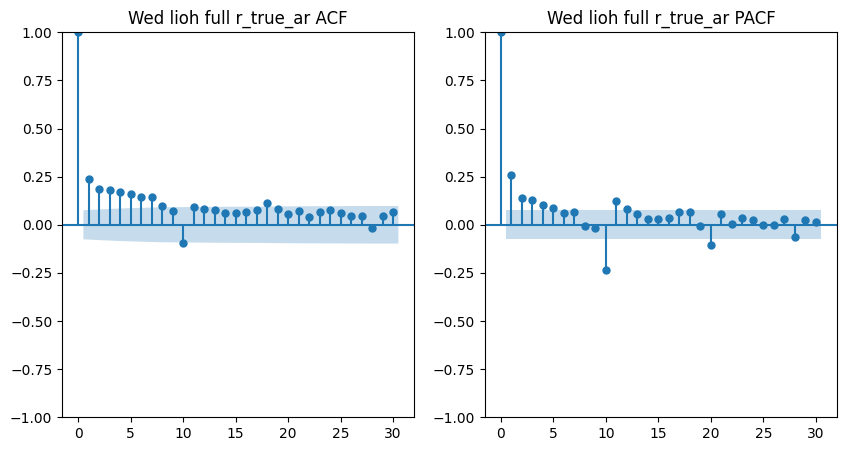

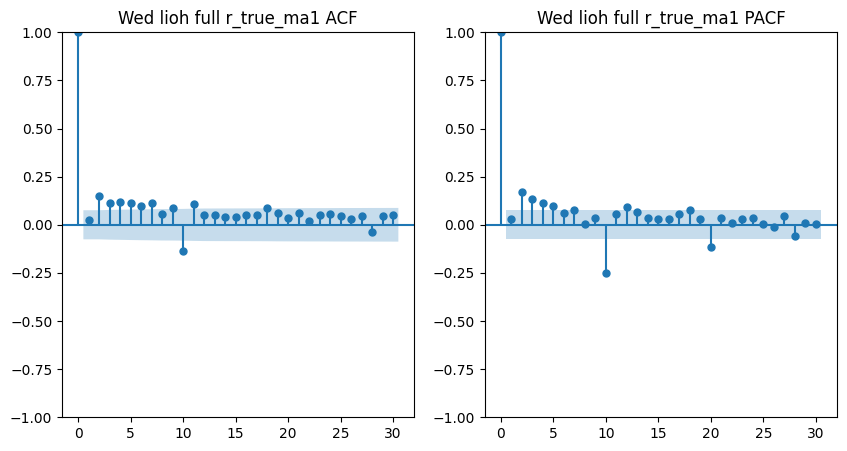

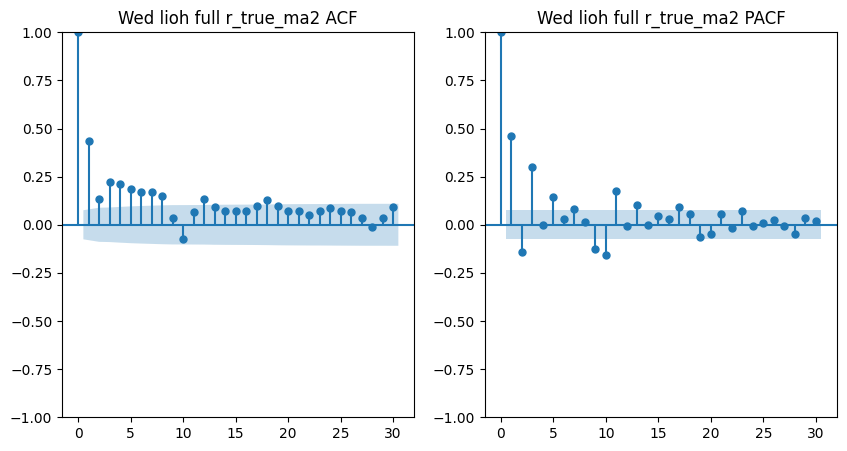

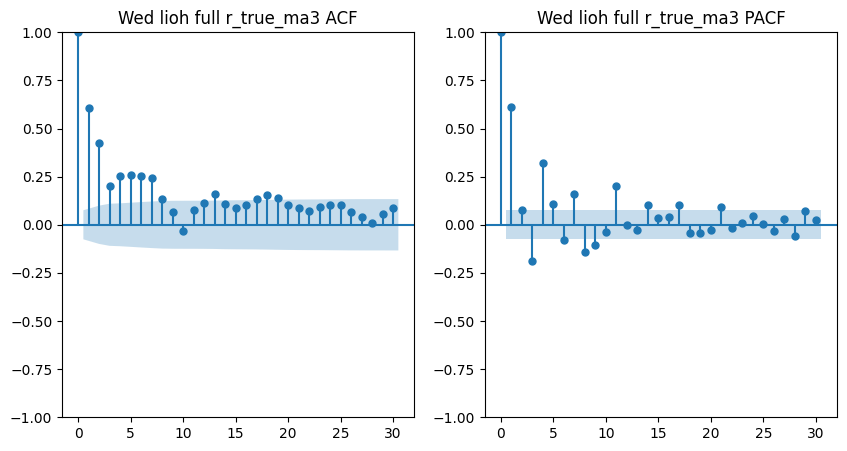

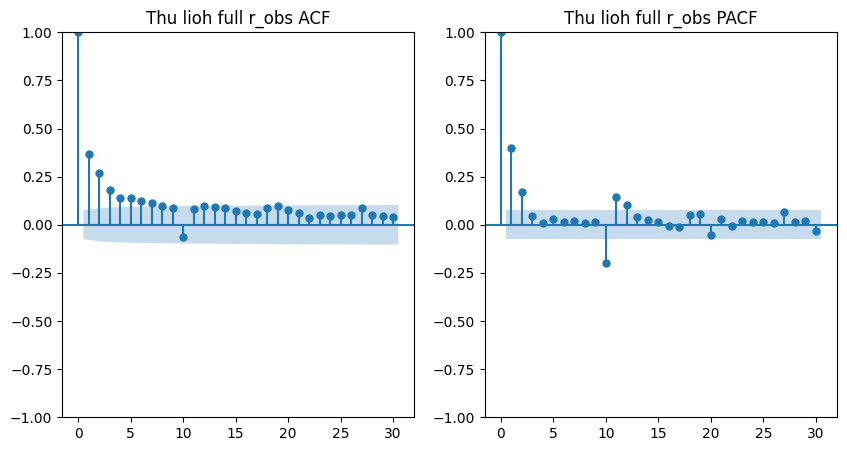

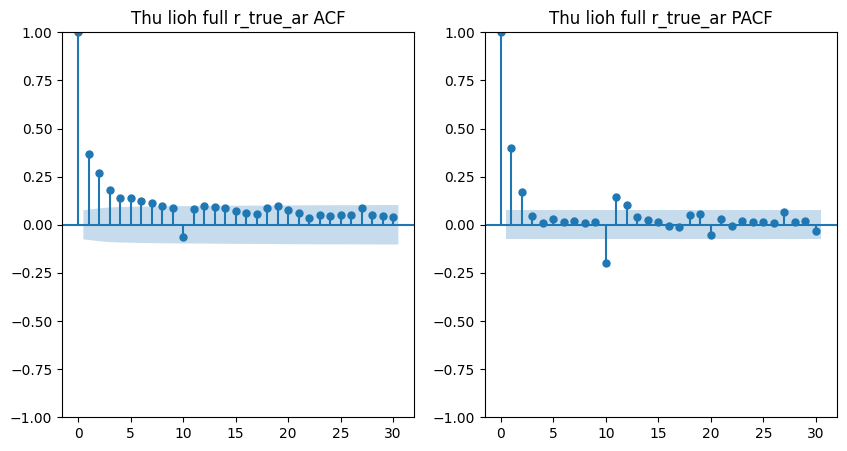

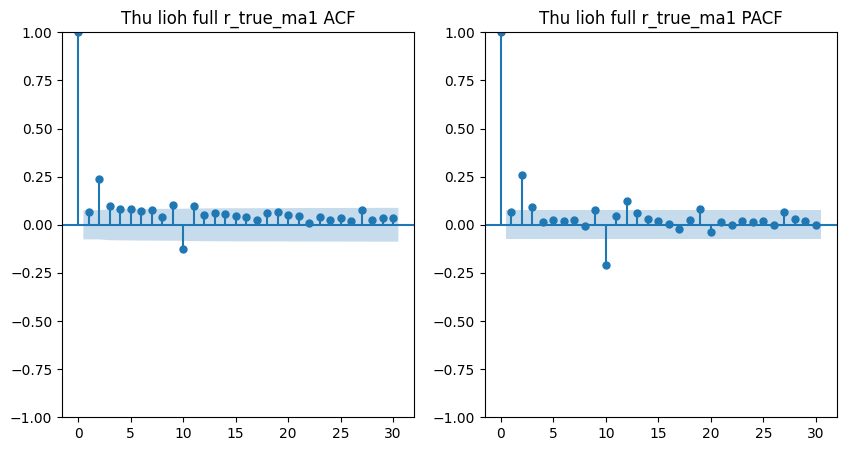

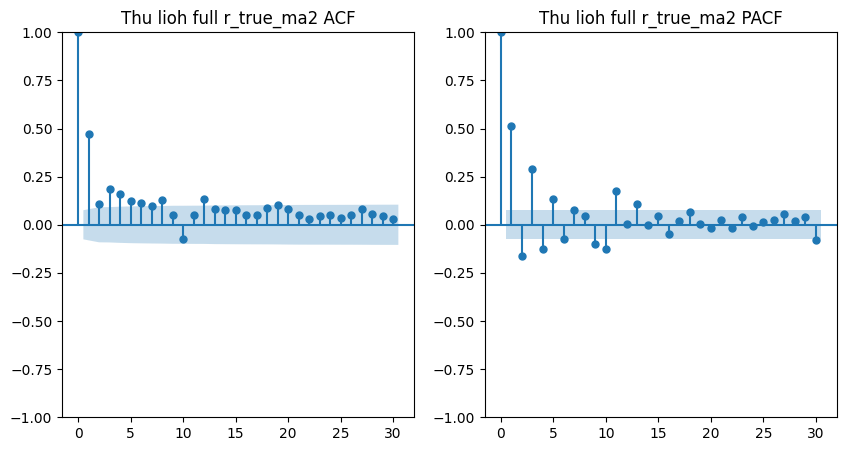

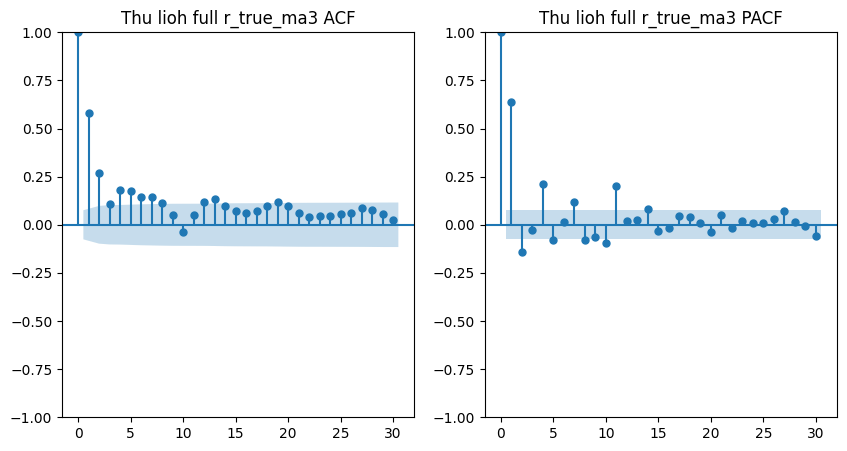

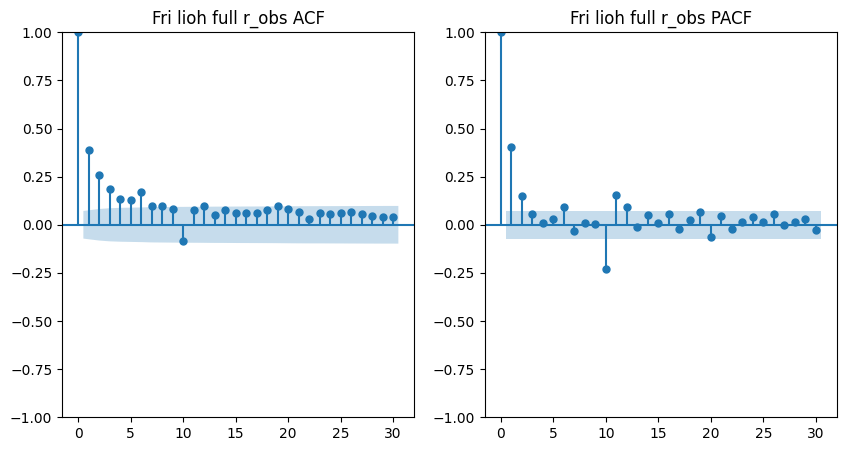

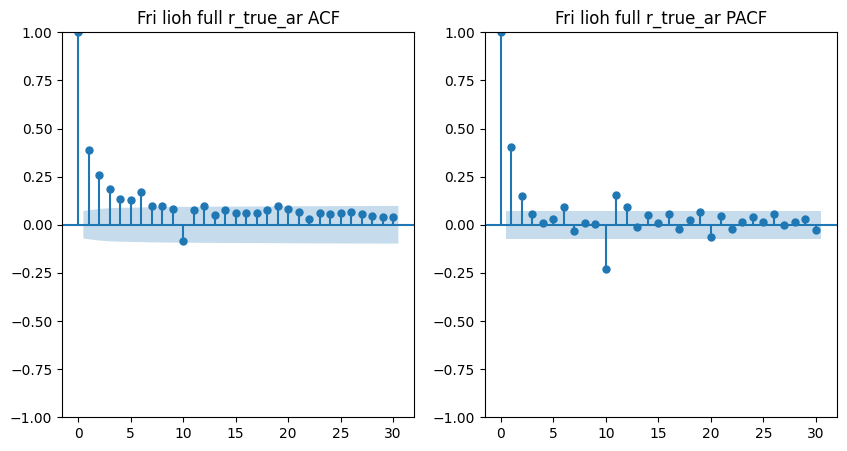

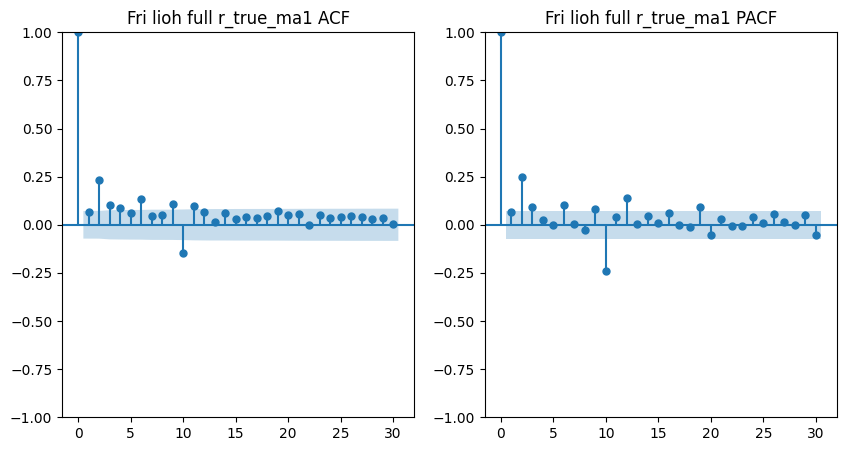

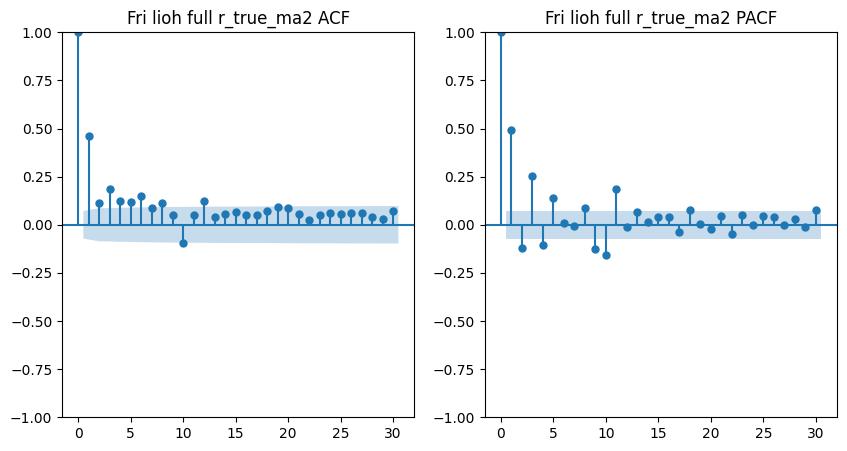

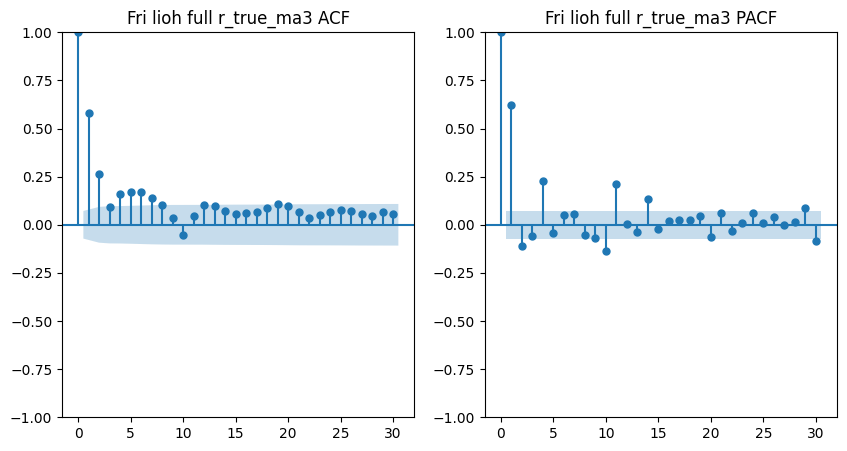

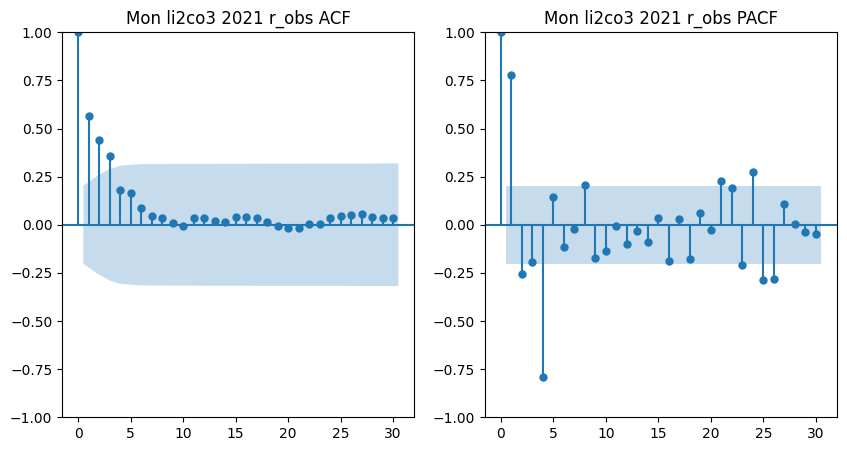

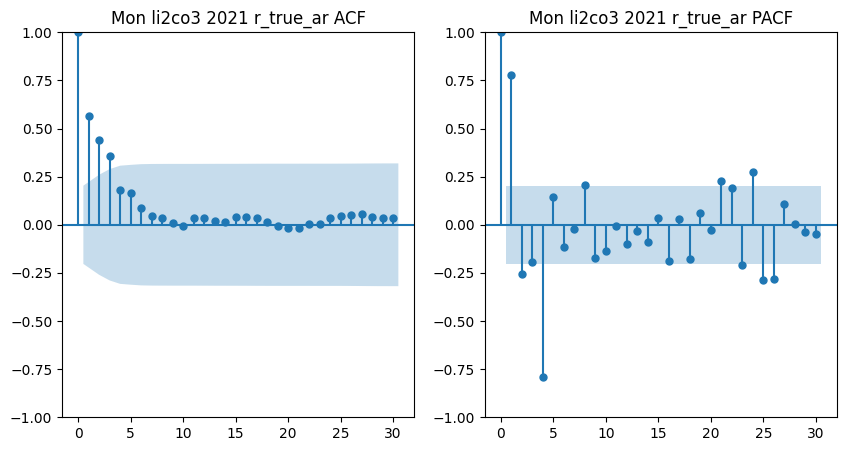

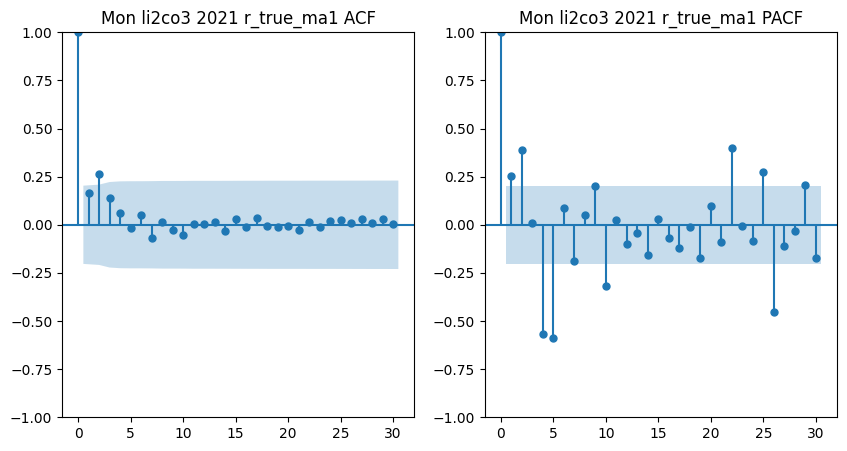

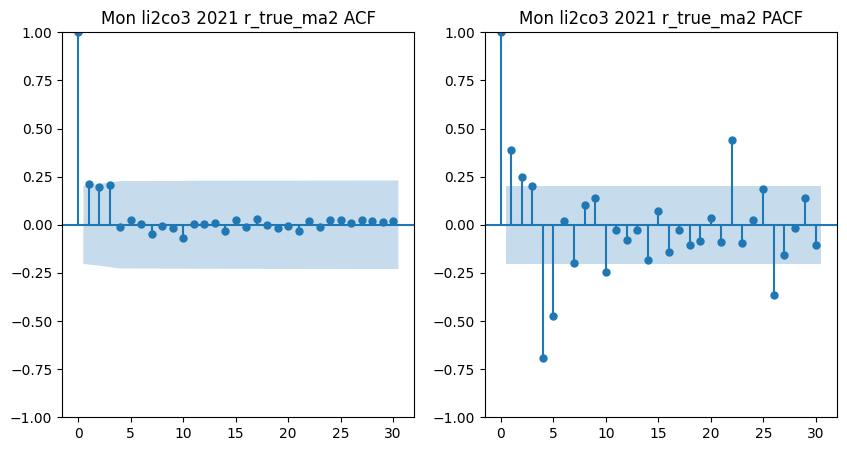

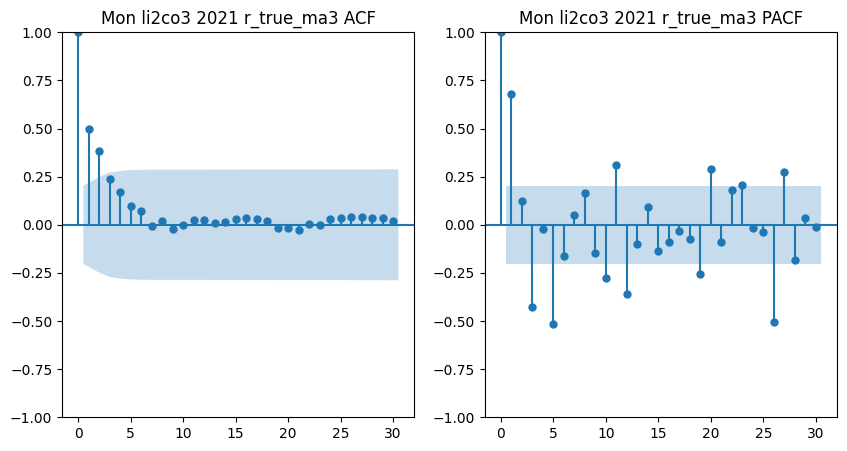

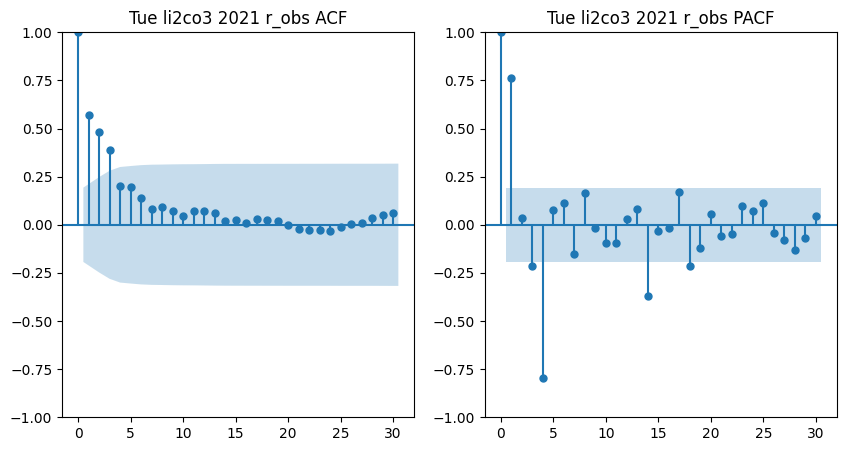

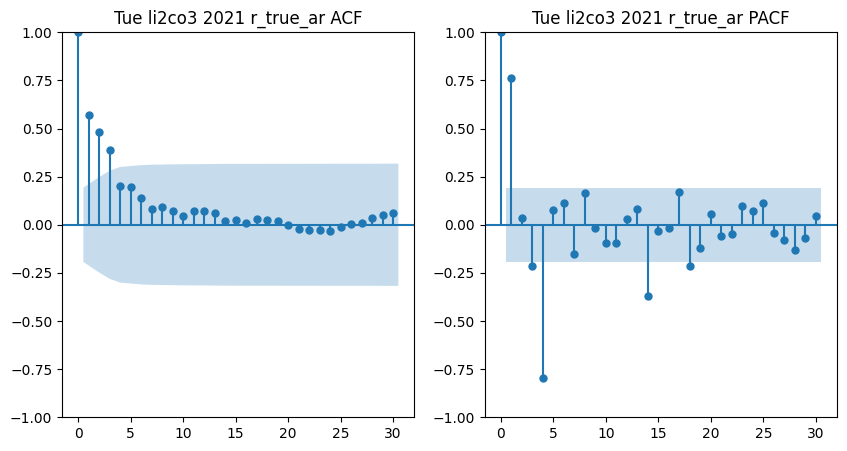

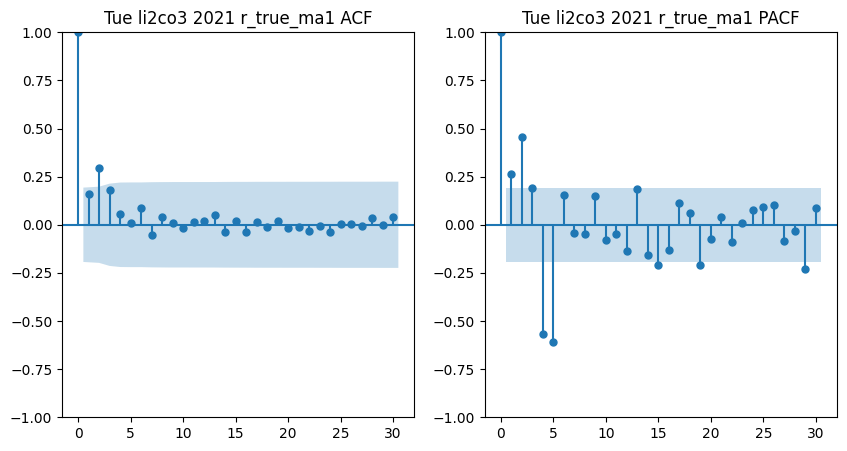

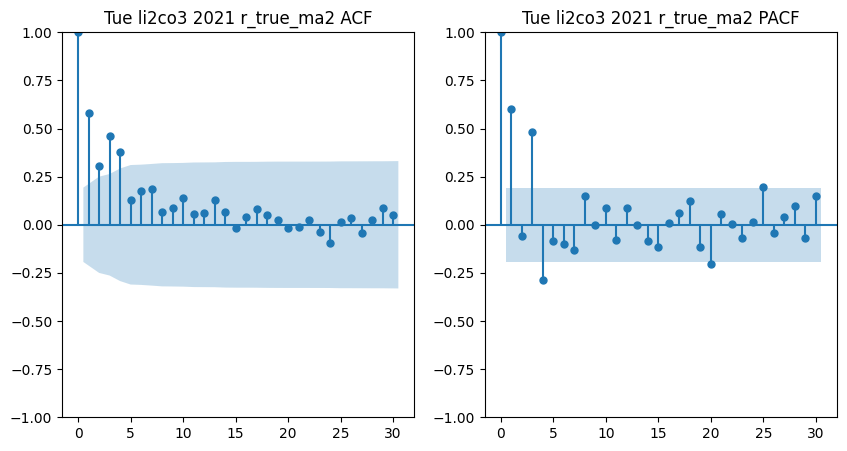

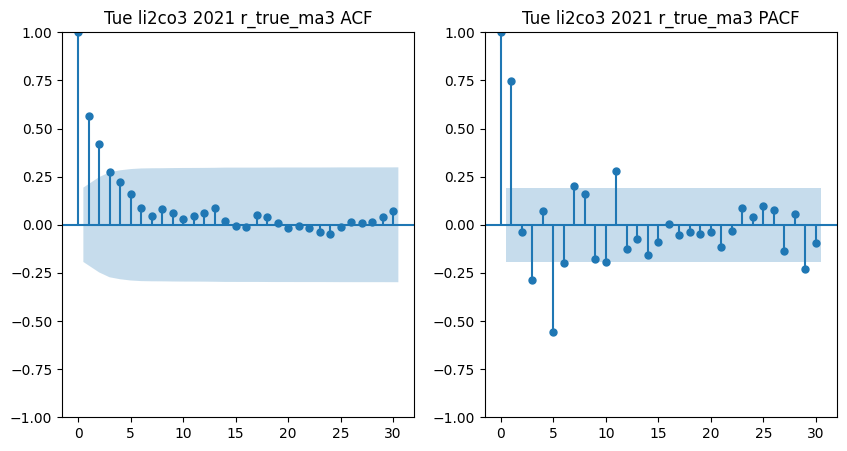

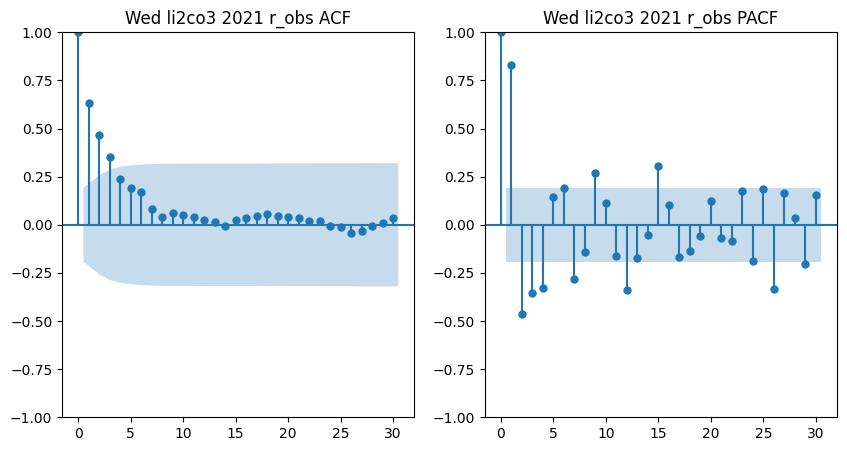

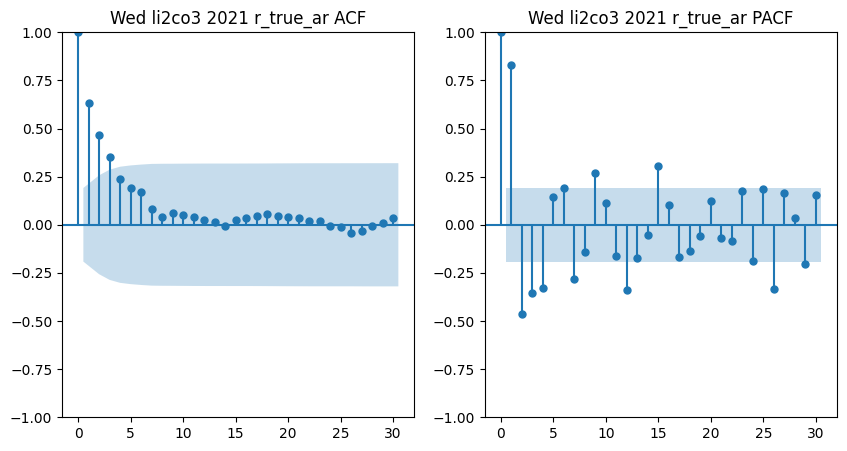

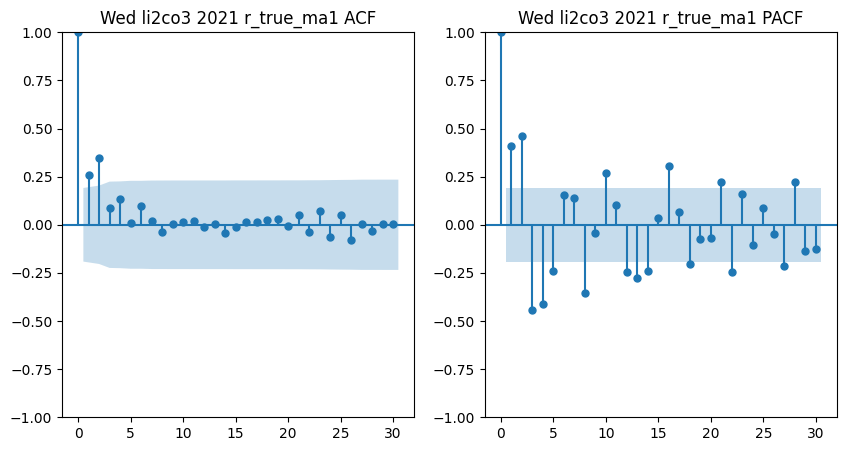

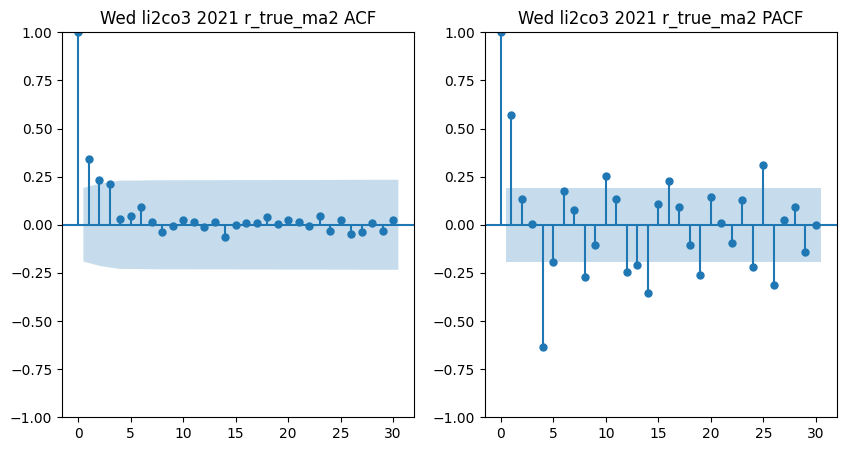

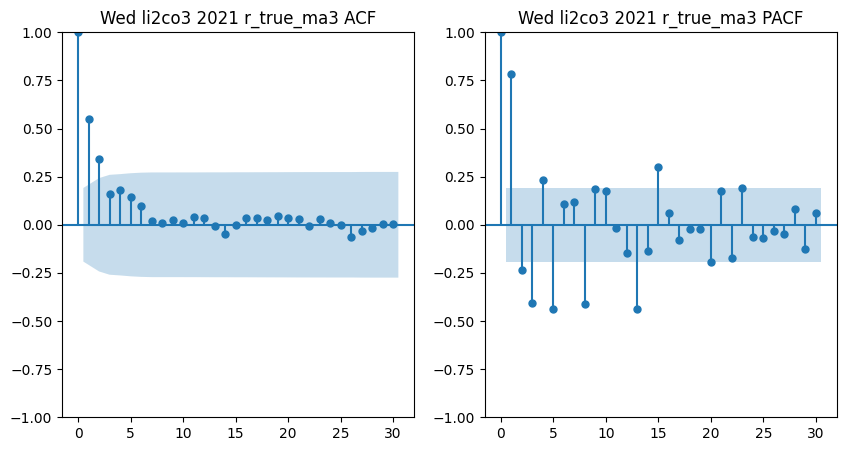

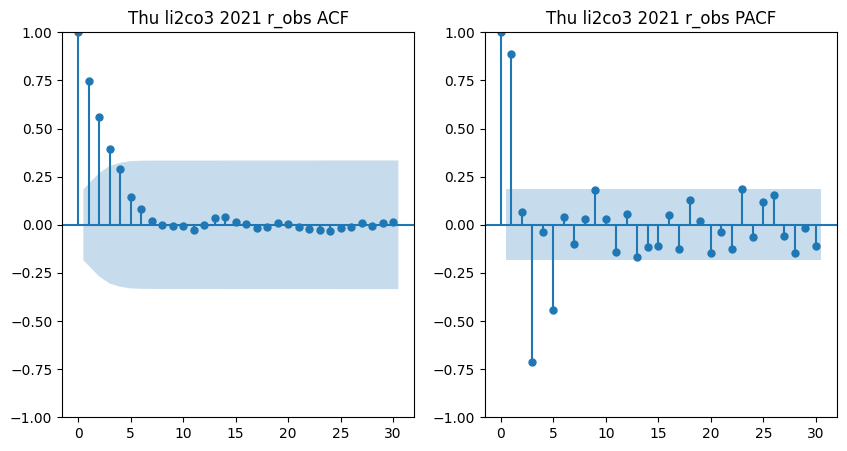

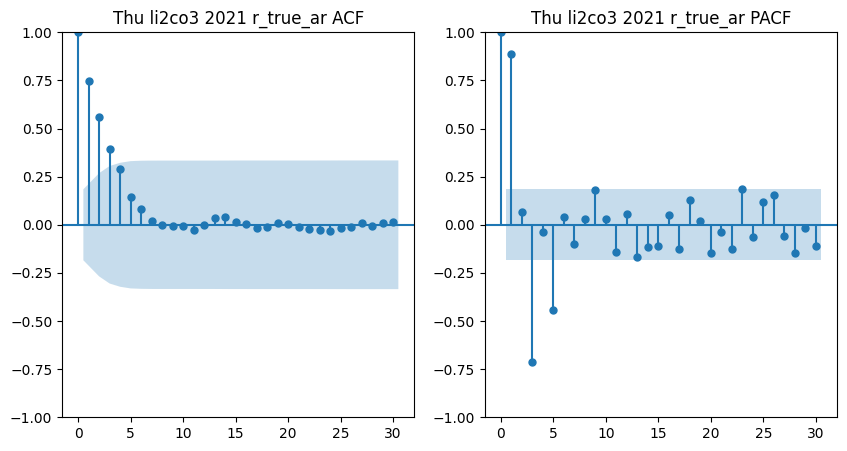

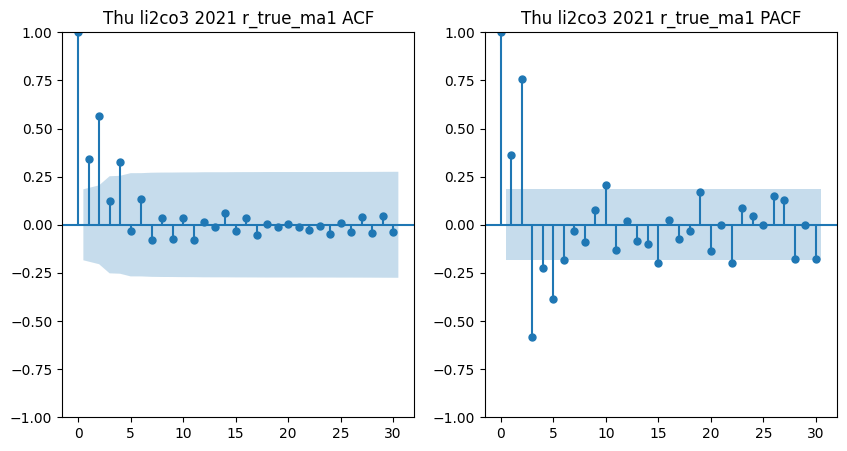

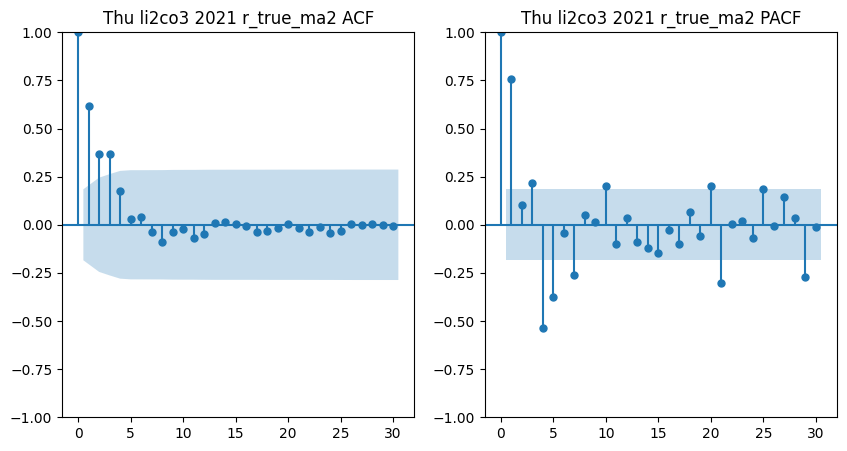

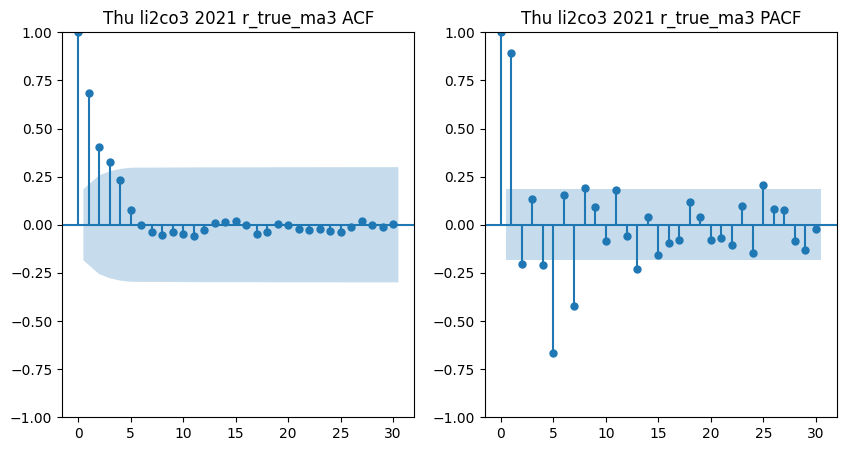

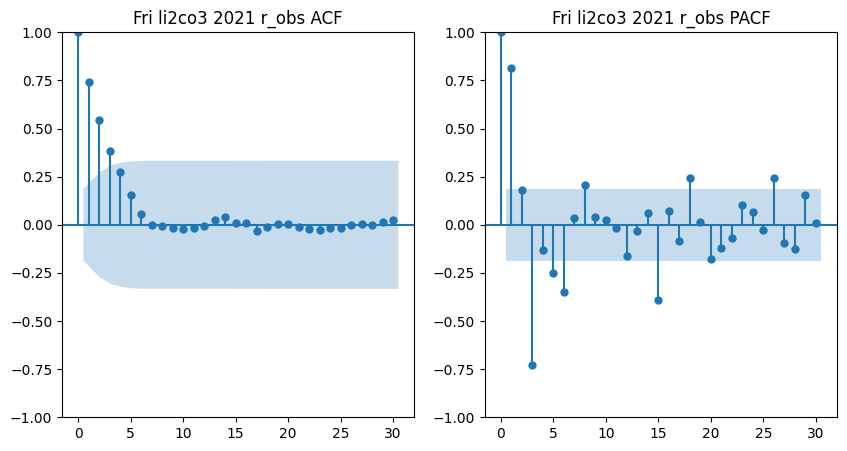

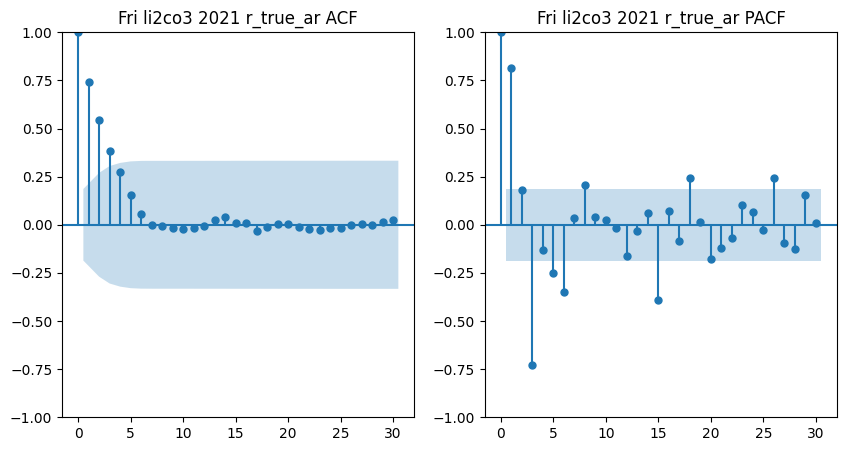

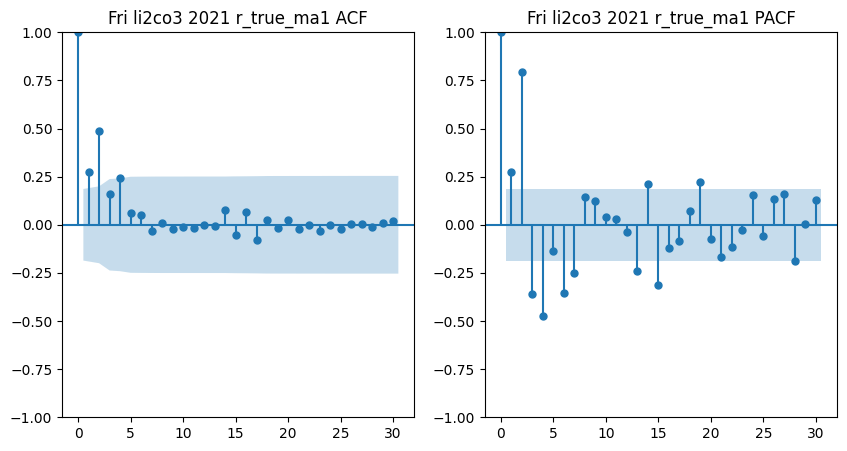

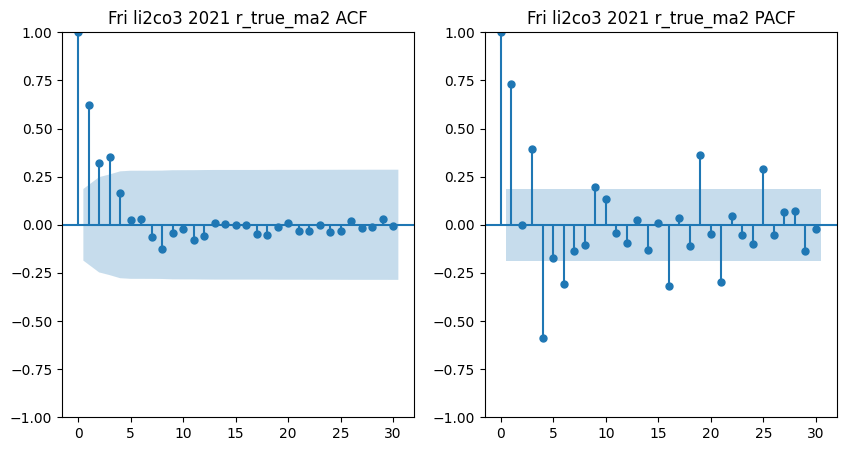

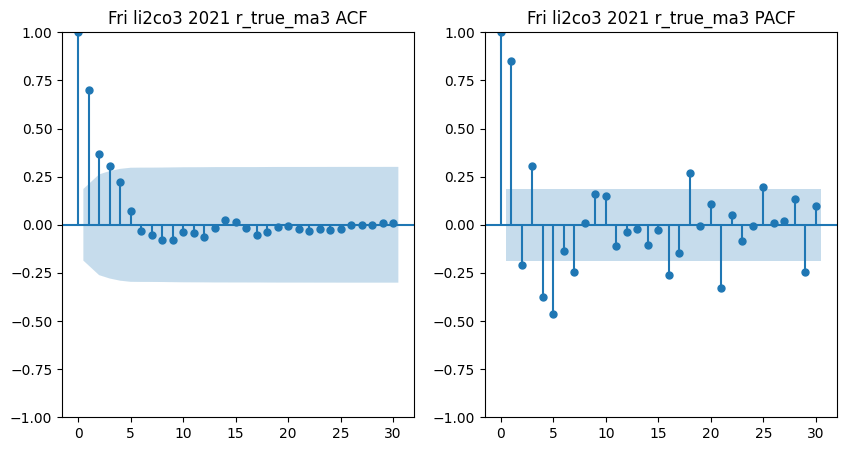

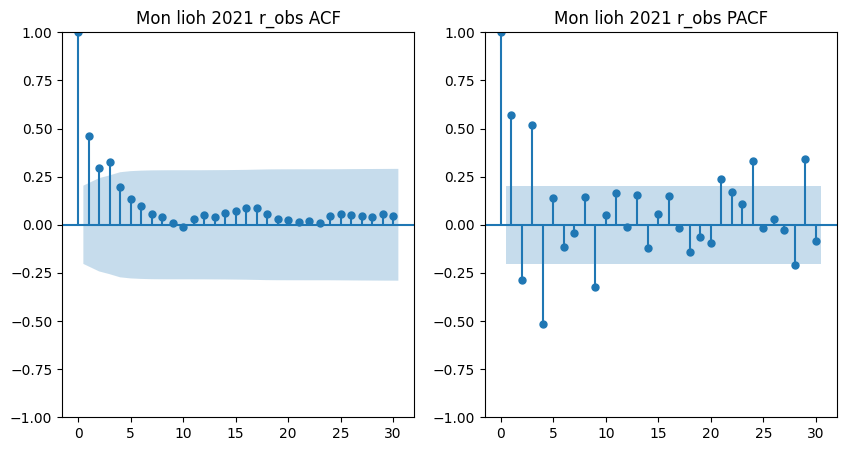

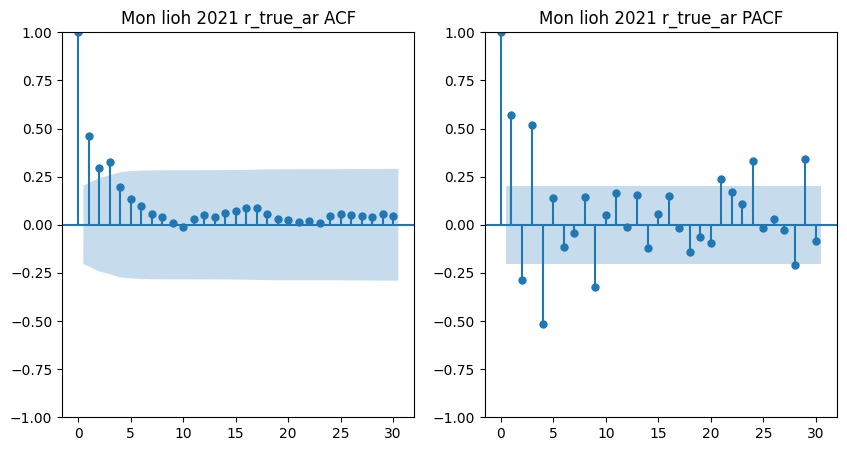

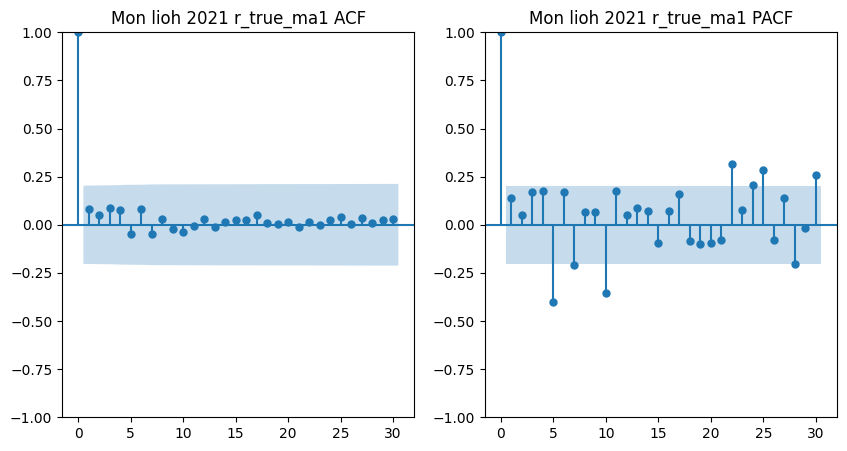

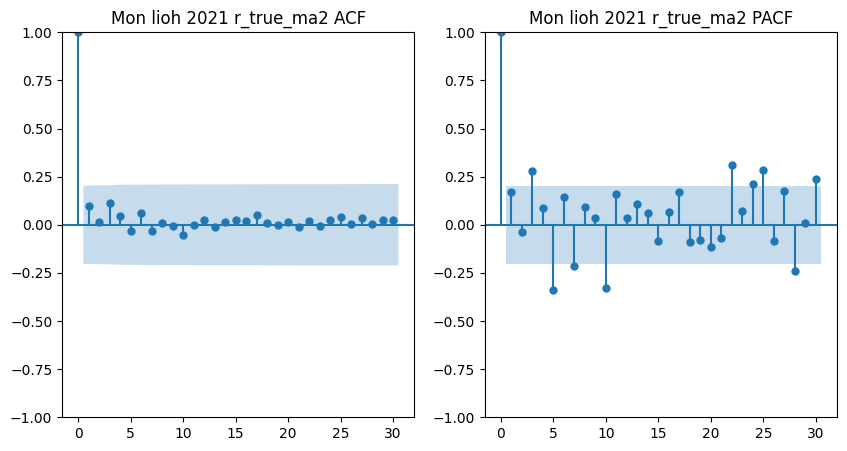

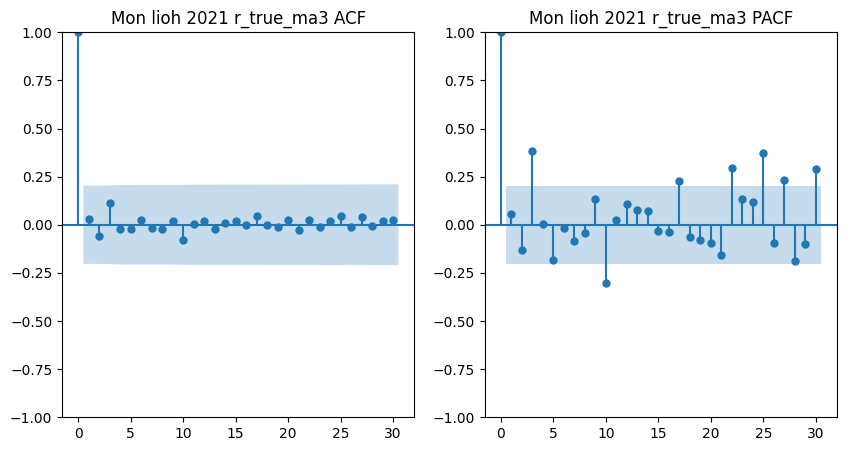

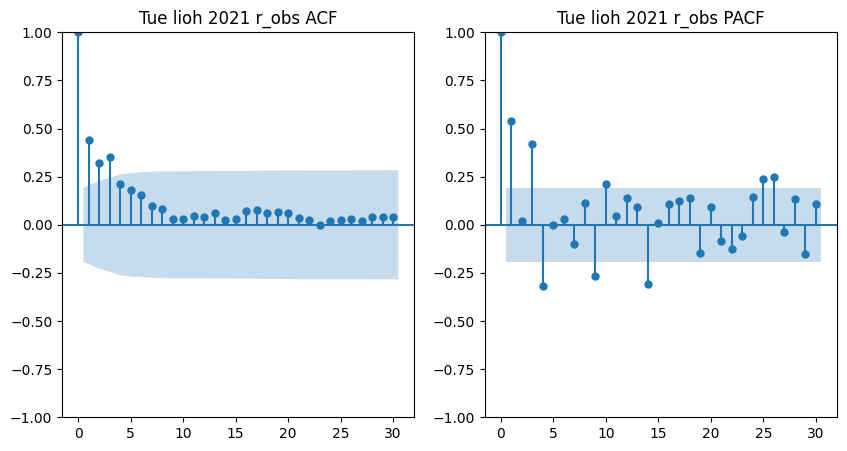

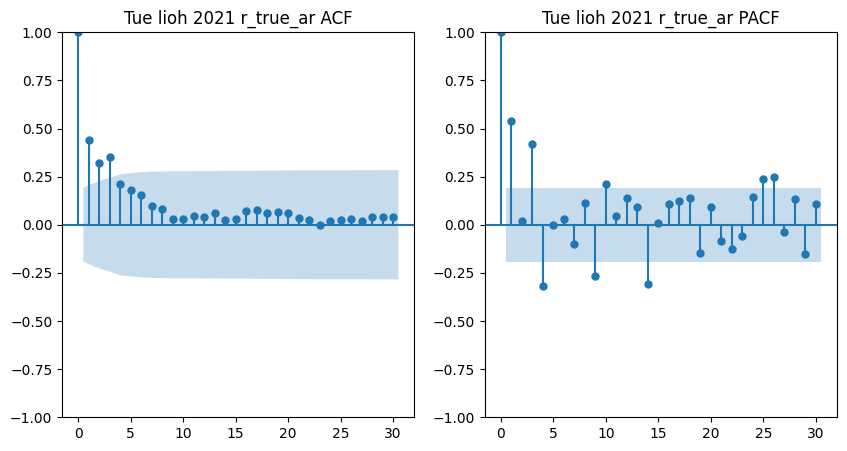

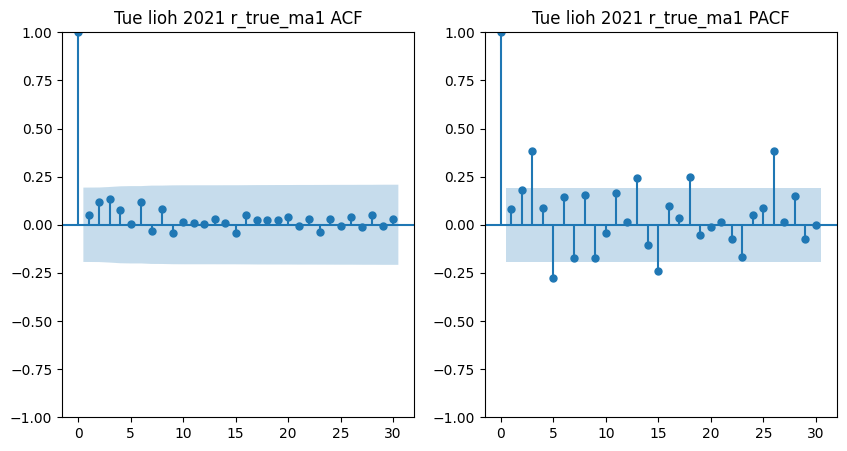

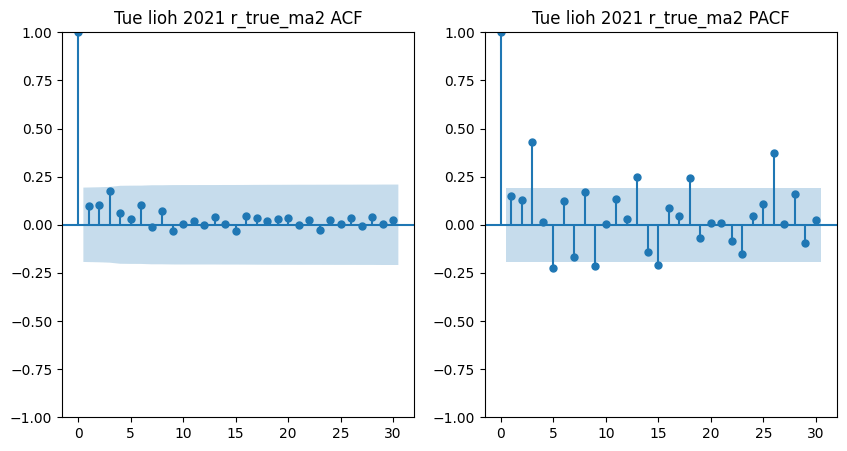

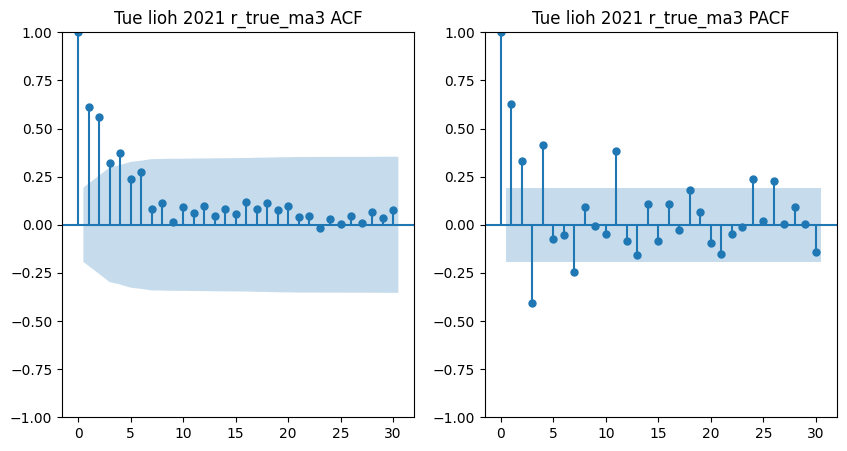

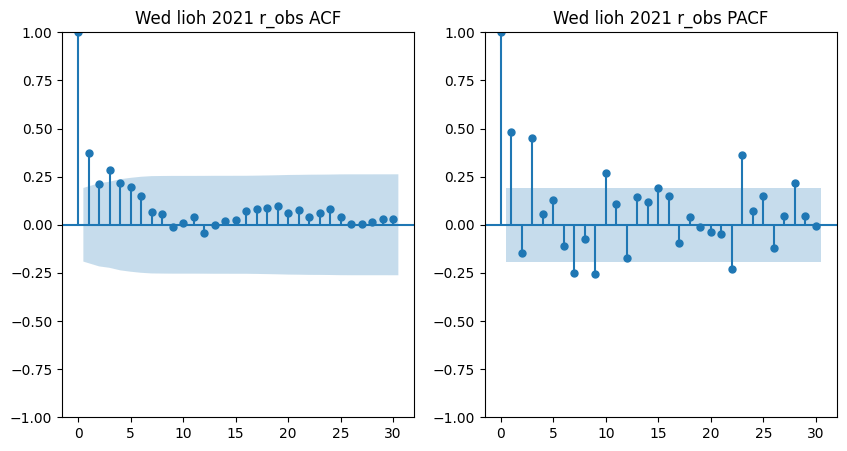

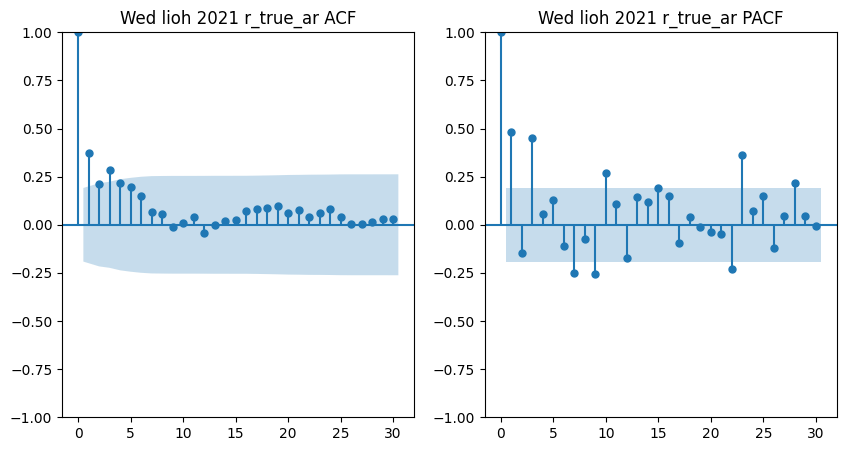

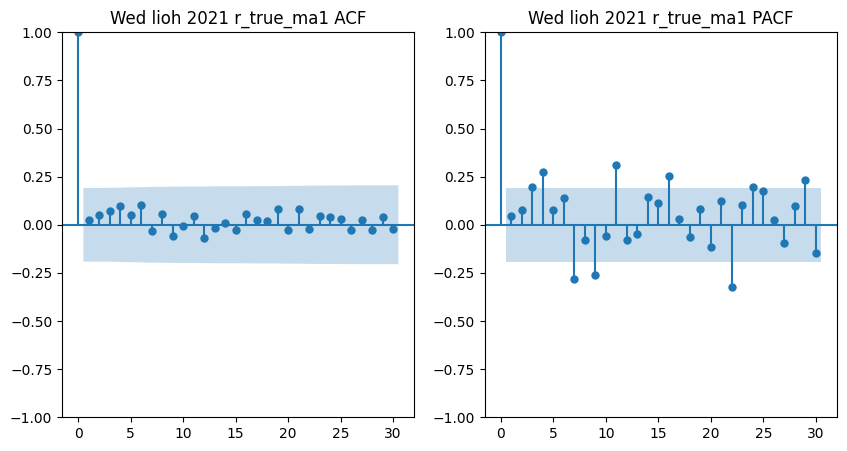

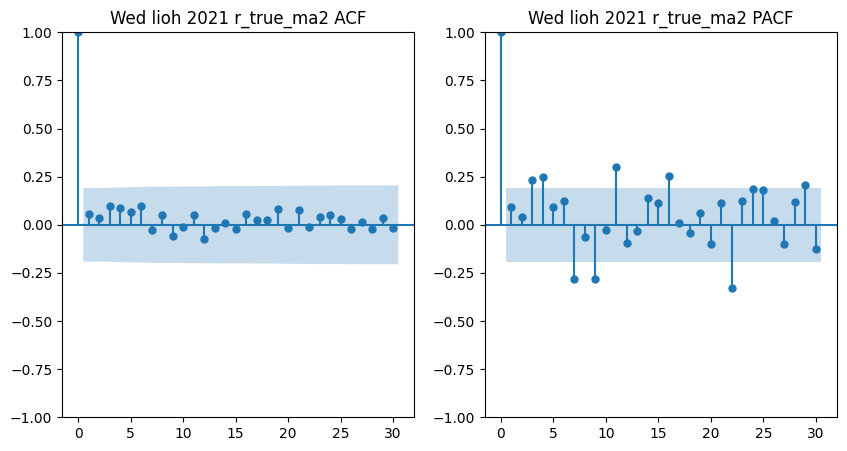

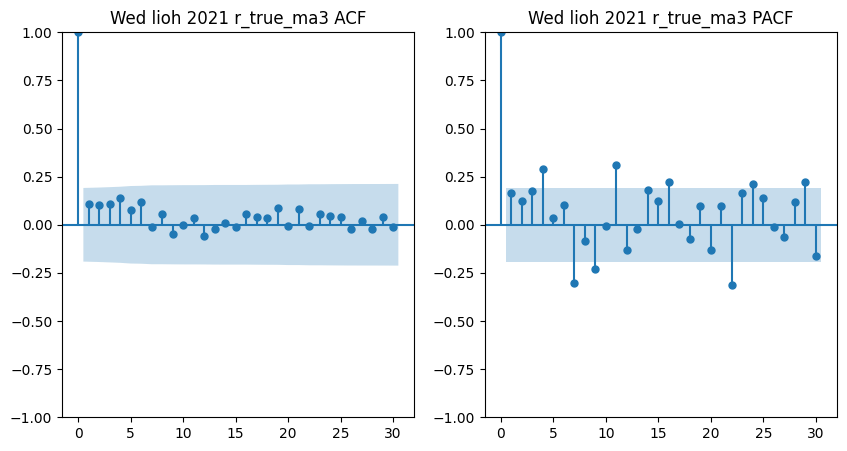

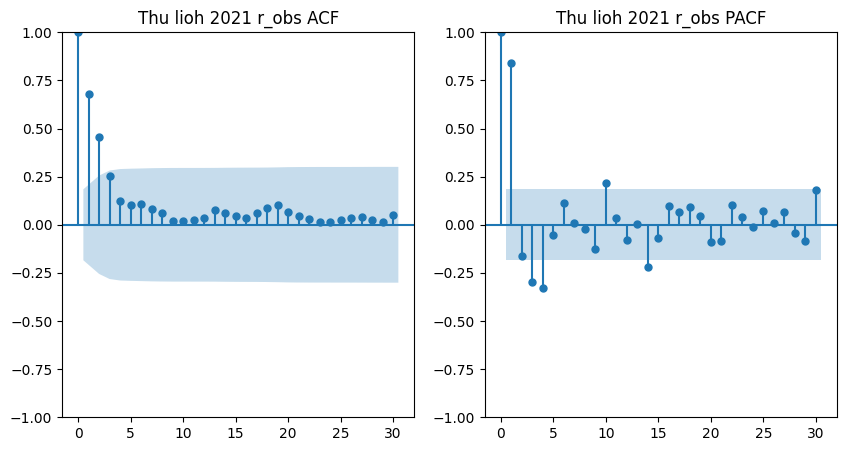

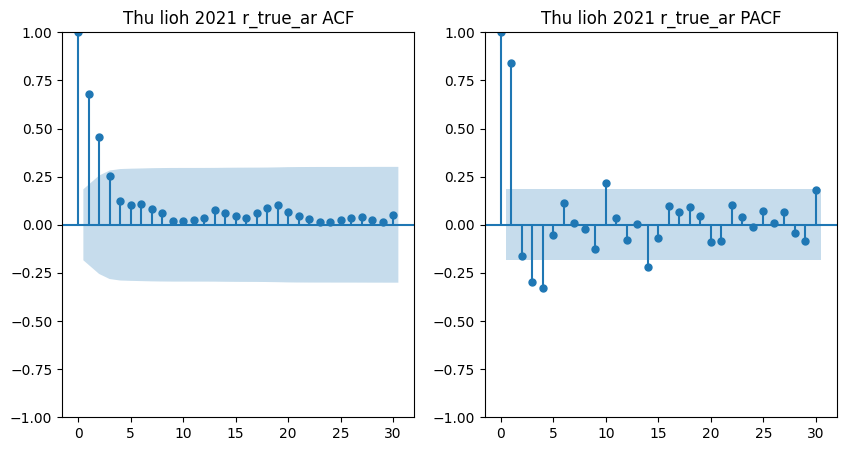

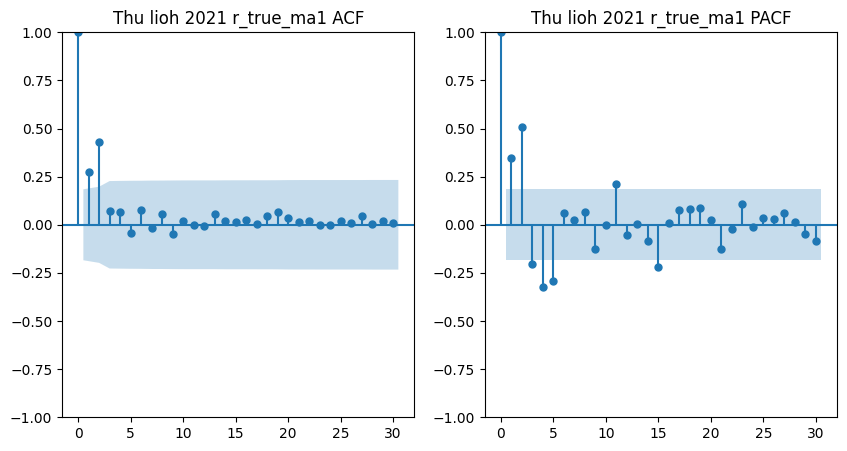

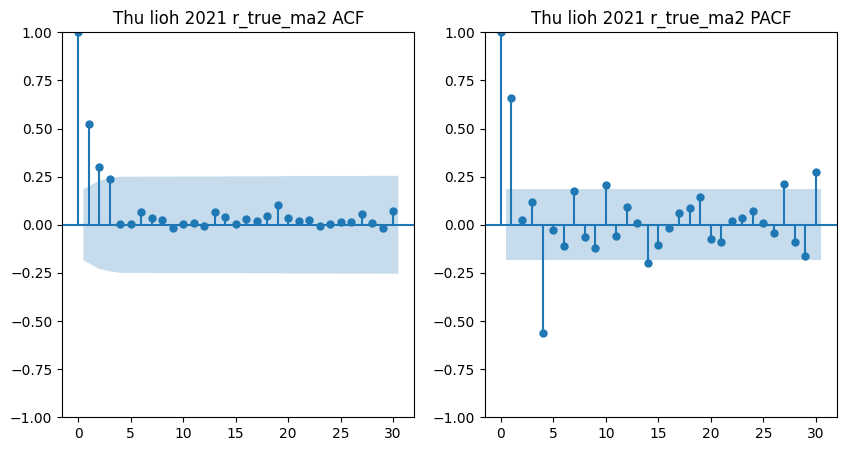

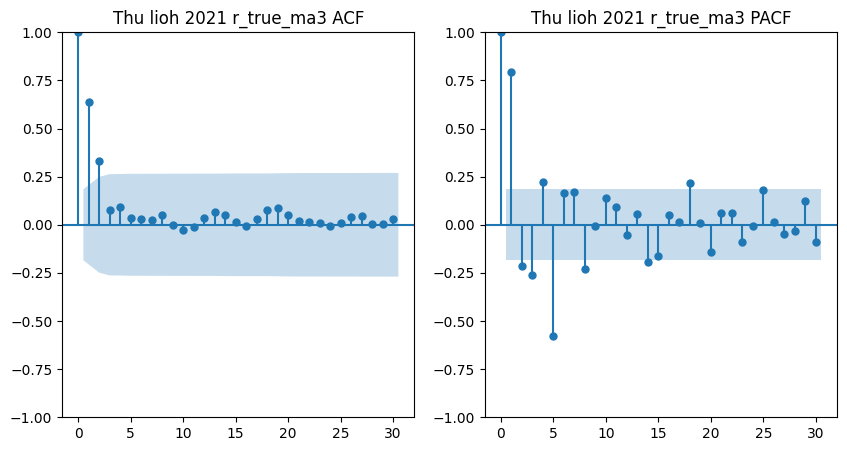

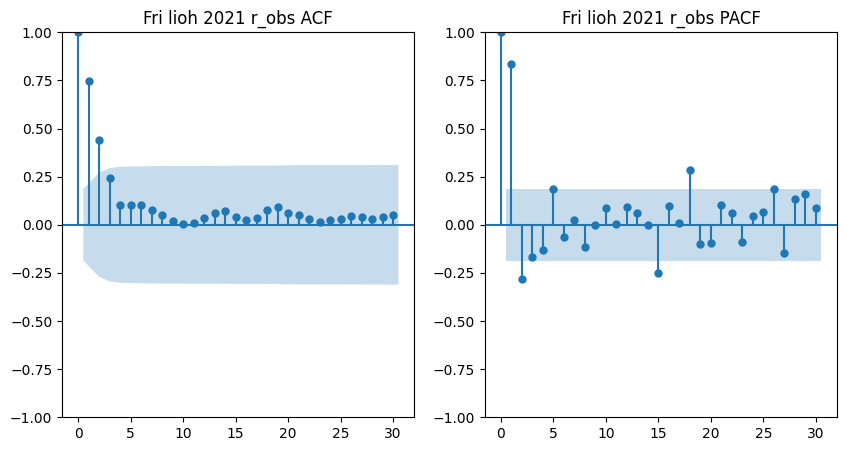

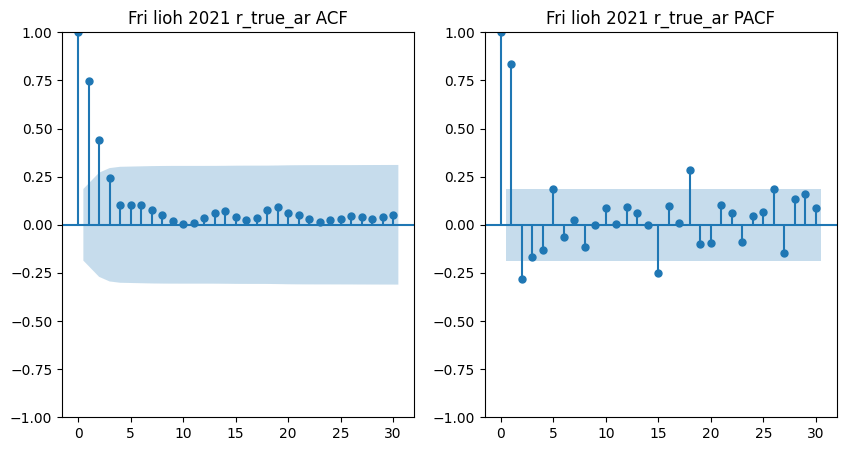

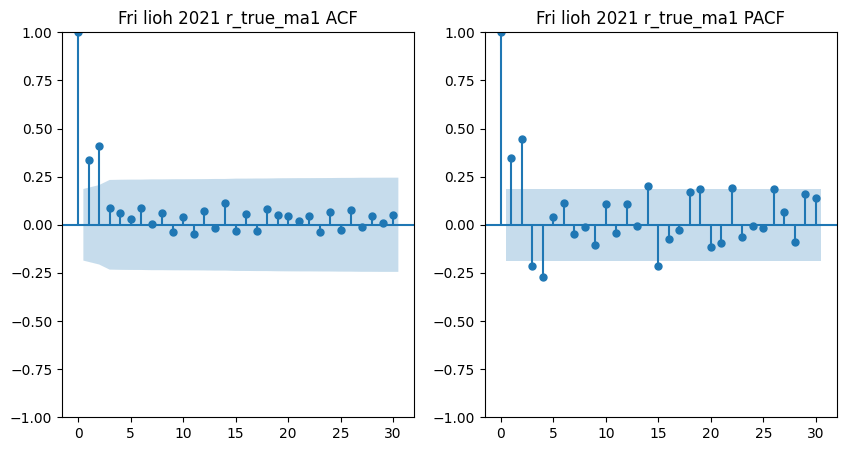

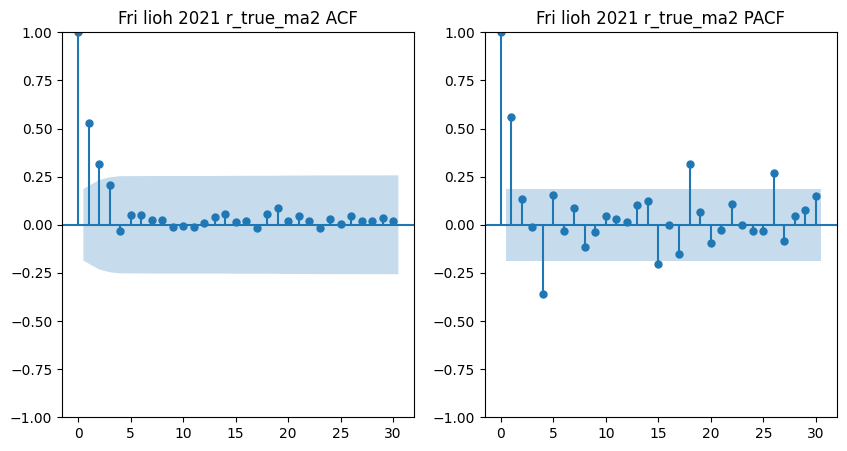

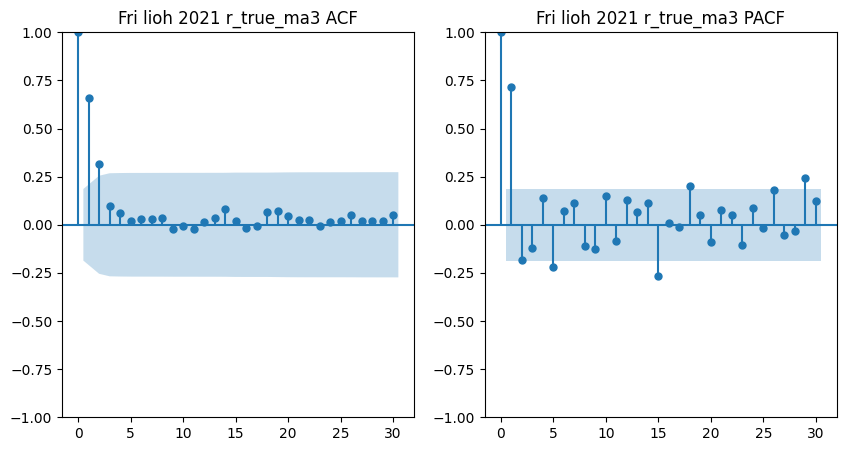

In [162]:
def plot_autocorr_unsmooth(i, df, dict_suffix): # i: 0-4; df: 'li2co3' / 'lioh'; dict_suffix: full / 2021
    
    temp = globals()[f'y_{i}_unsmooth_{dict_suffix}'][df]
    cols = temp.columns.to_list()
    
    for r in range(len(cols)):
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        plot_acf(temp[cols[r]].dropna(), lags=30, alpha = 0.05, title = f'{calendar.day_abbr[i]} {df} {dict_suffix} {cols[r]} ACF', ax=ax[0])
        plot_pacf(temp[cols[r]].dropna(), lags=30, alpha = 0.05, method = 'ols', title = f'{calendar.day_abbr[i]} {df} {dict_suffix} {cols[r]} PACF', ax=ax[1])
        plt.savefig(f'./unsmoothed_y_autocorr/{calendar.day_abbr[i]}_{df}_{dict_suffix}_{cols[r]}.png')

for dict_suffix in ['full','2021']:
    for df in ['li2co3','lioh']:
        for i in range(5):
            plot_autocorr_unsmooth(i, df, dict_suffix)
        

### Correlation Accross Y Series

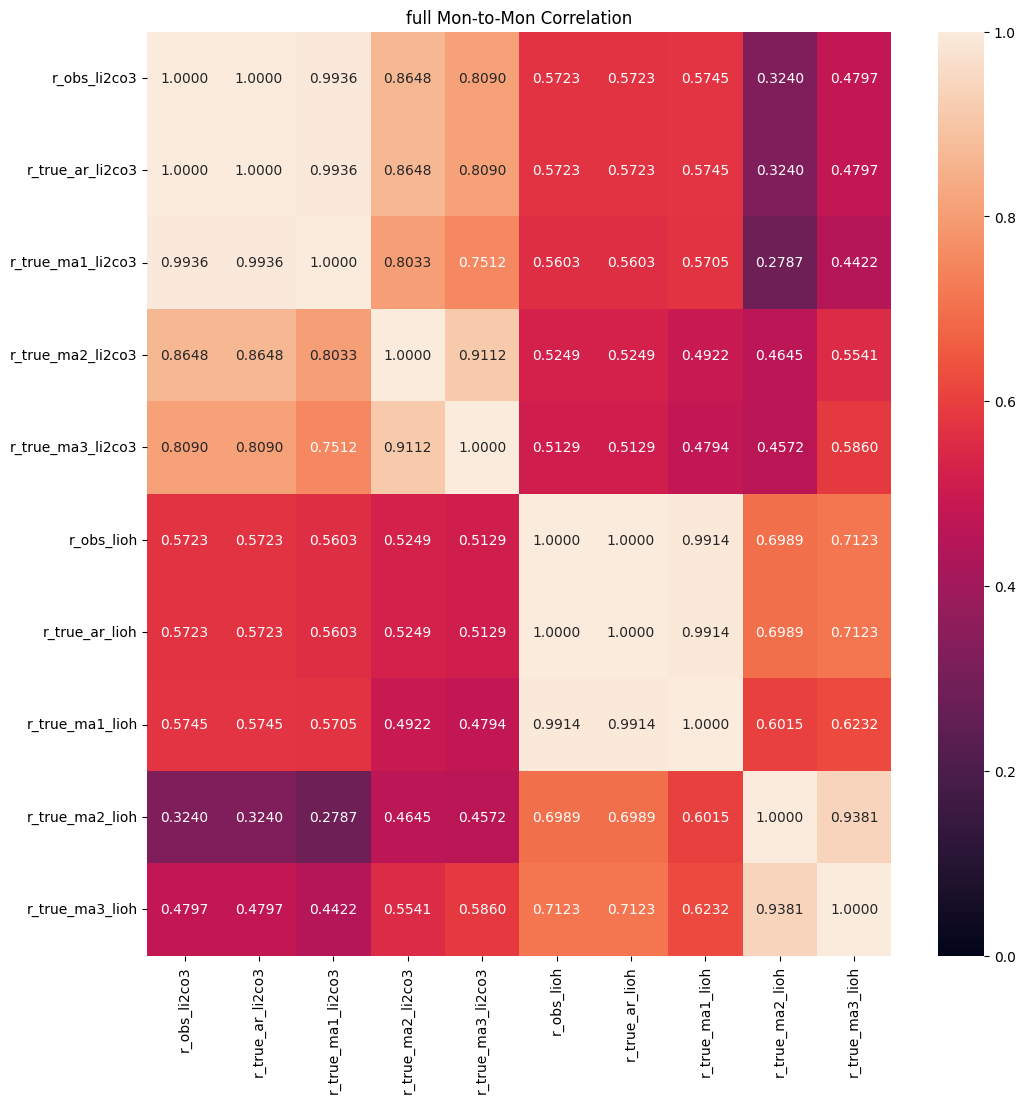

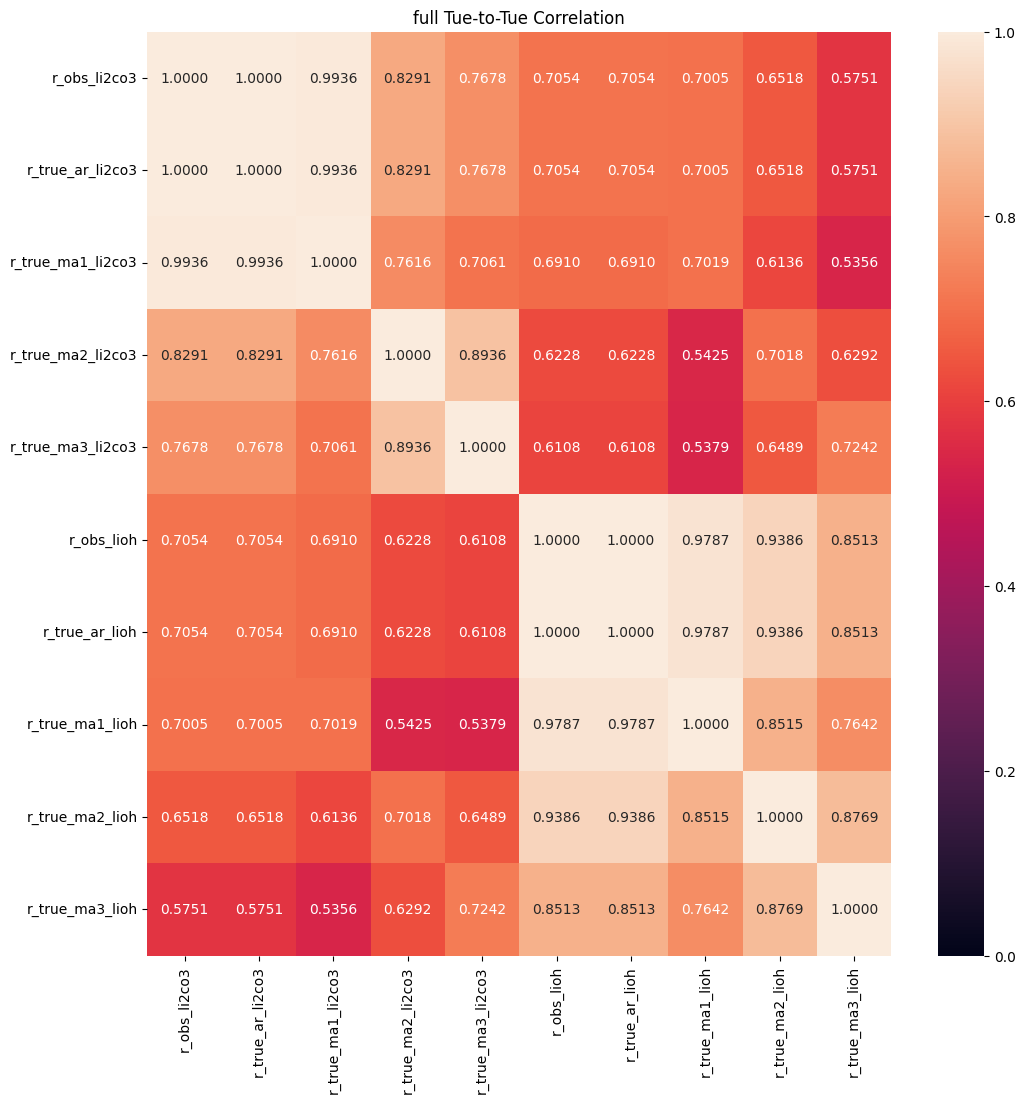

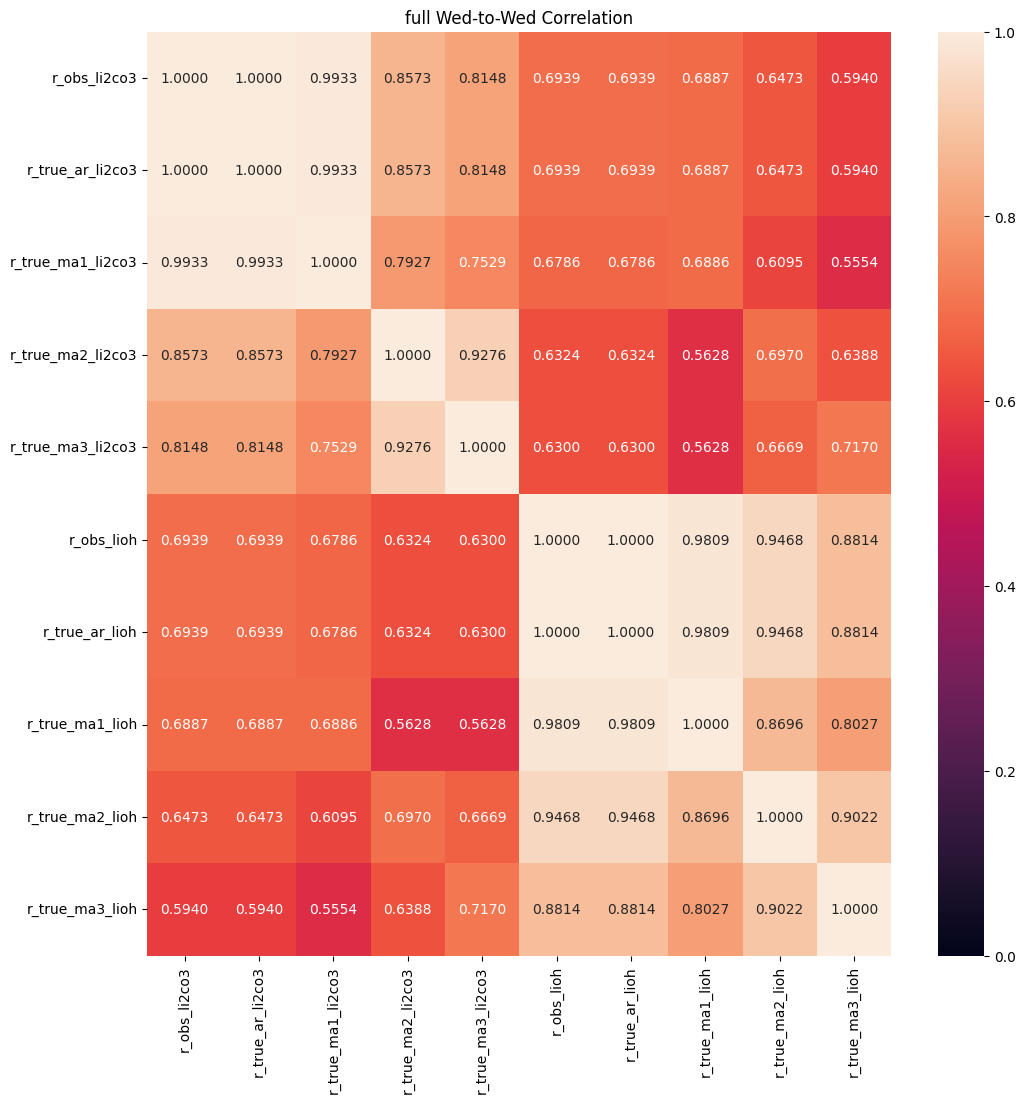

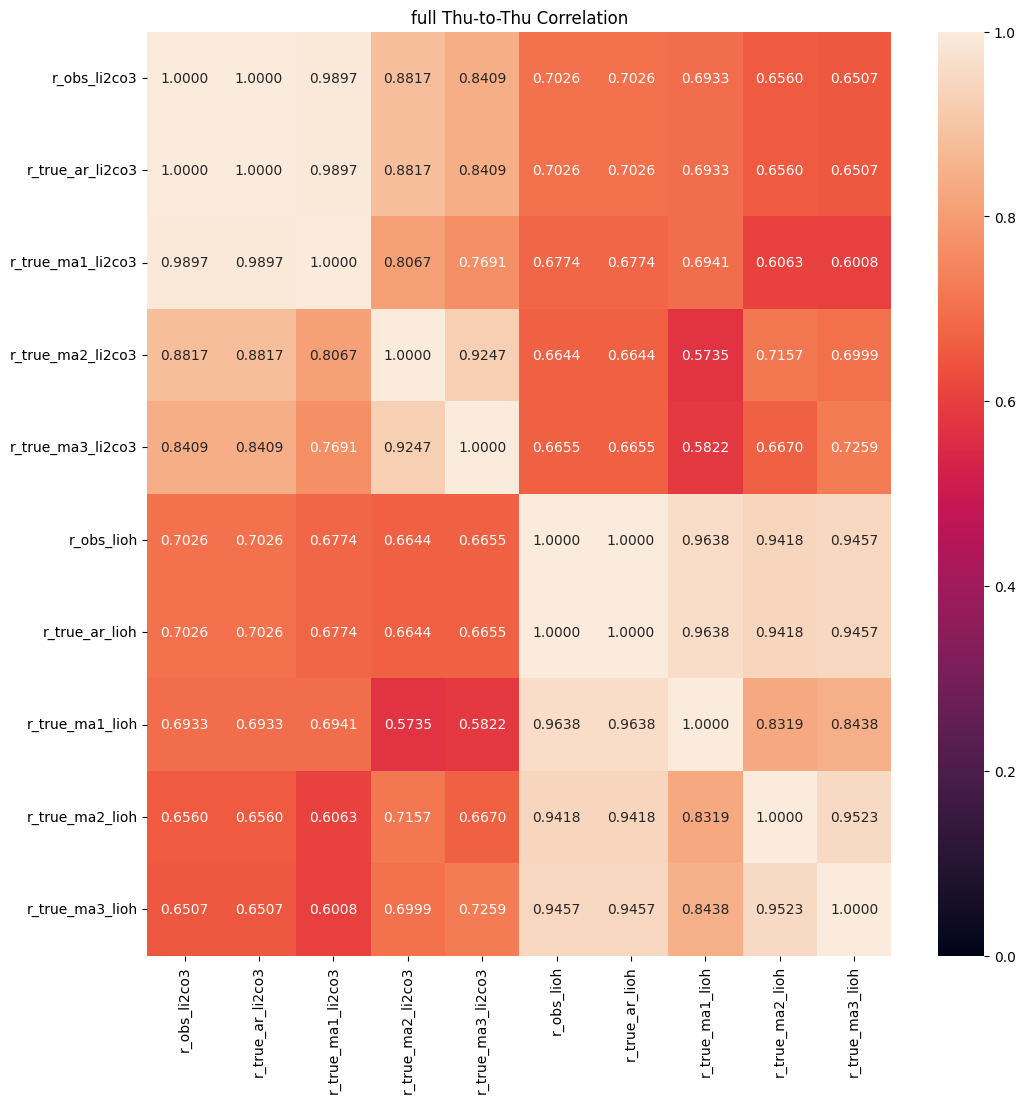

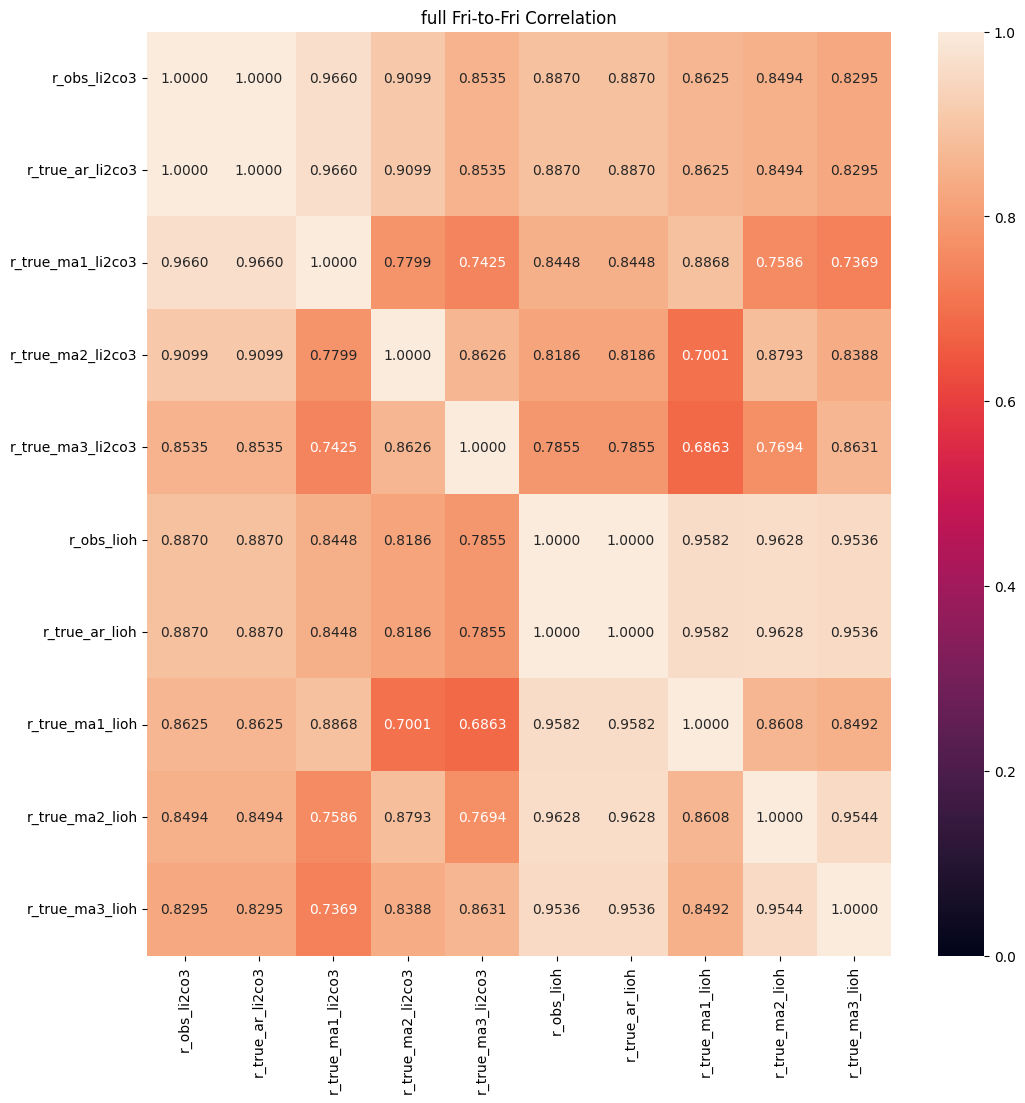

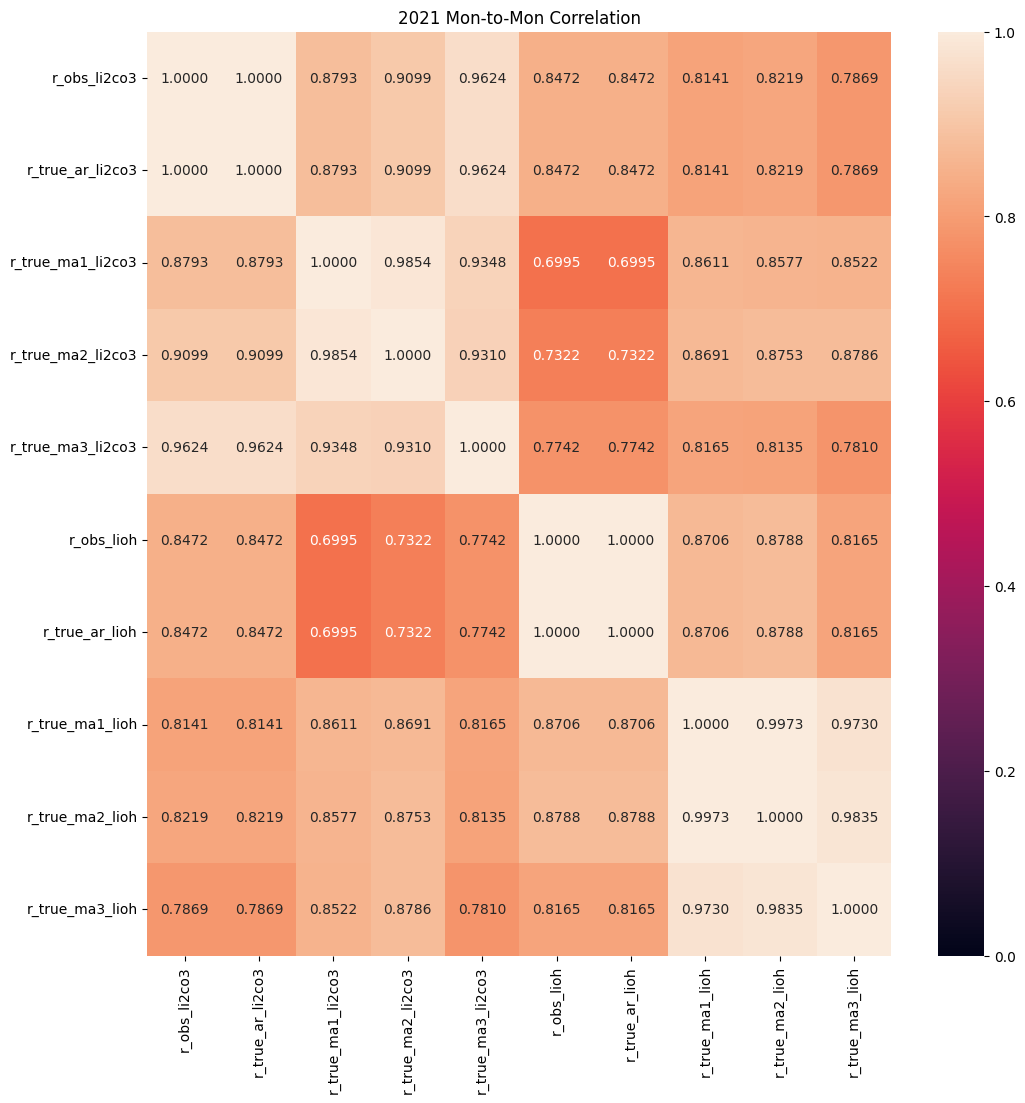

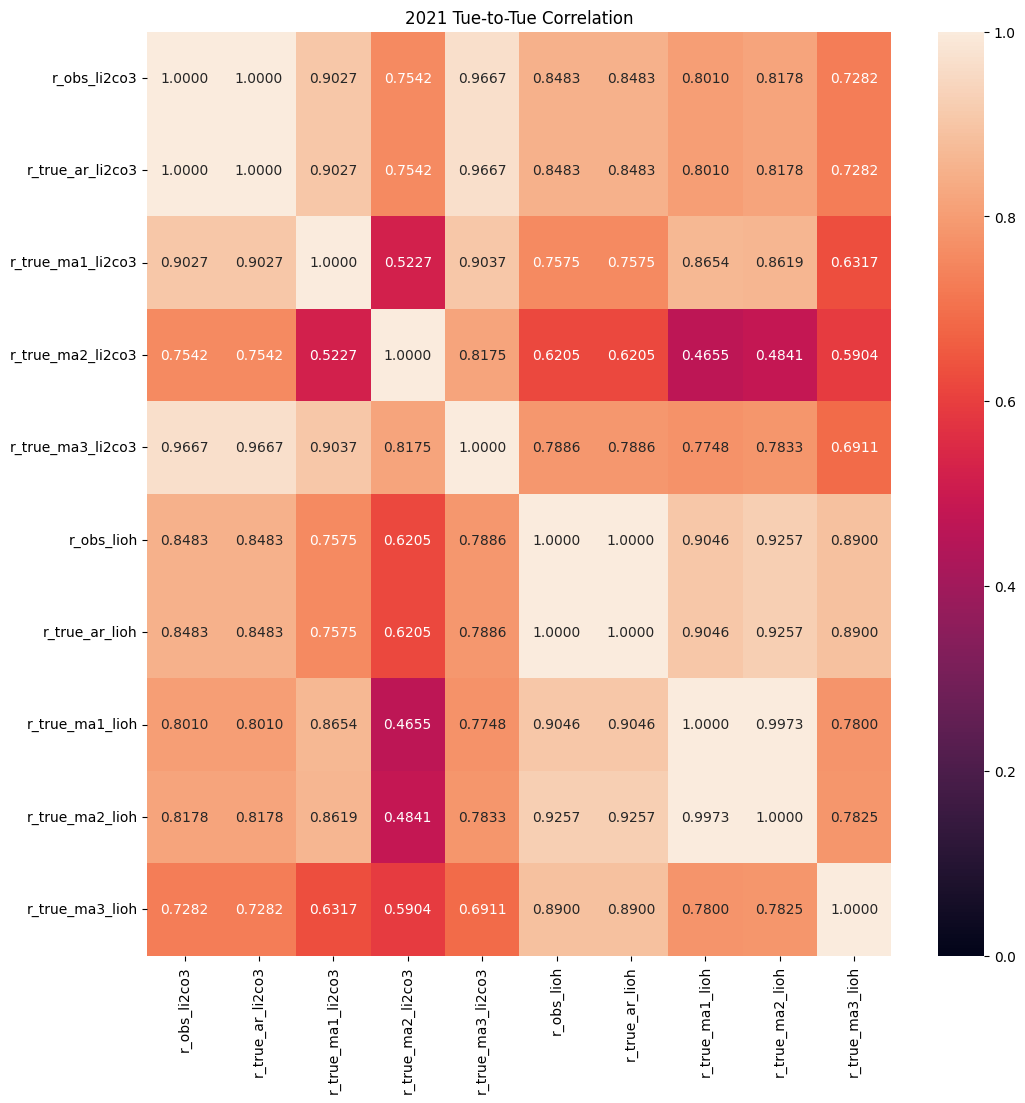

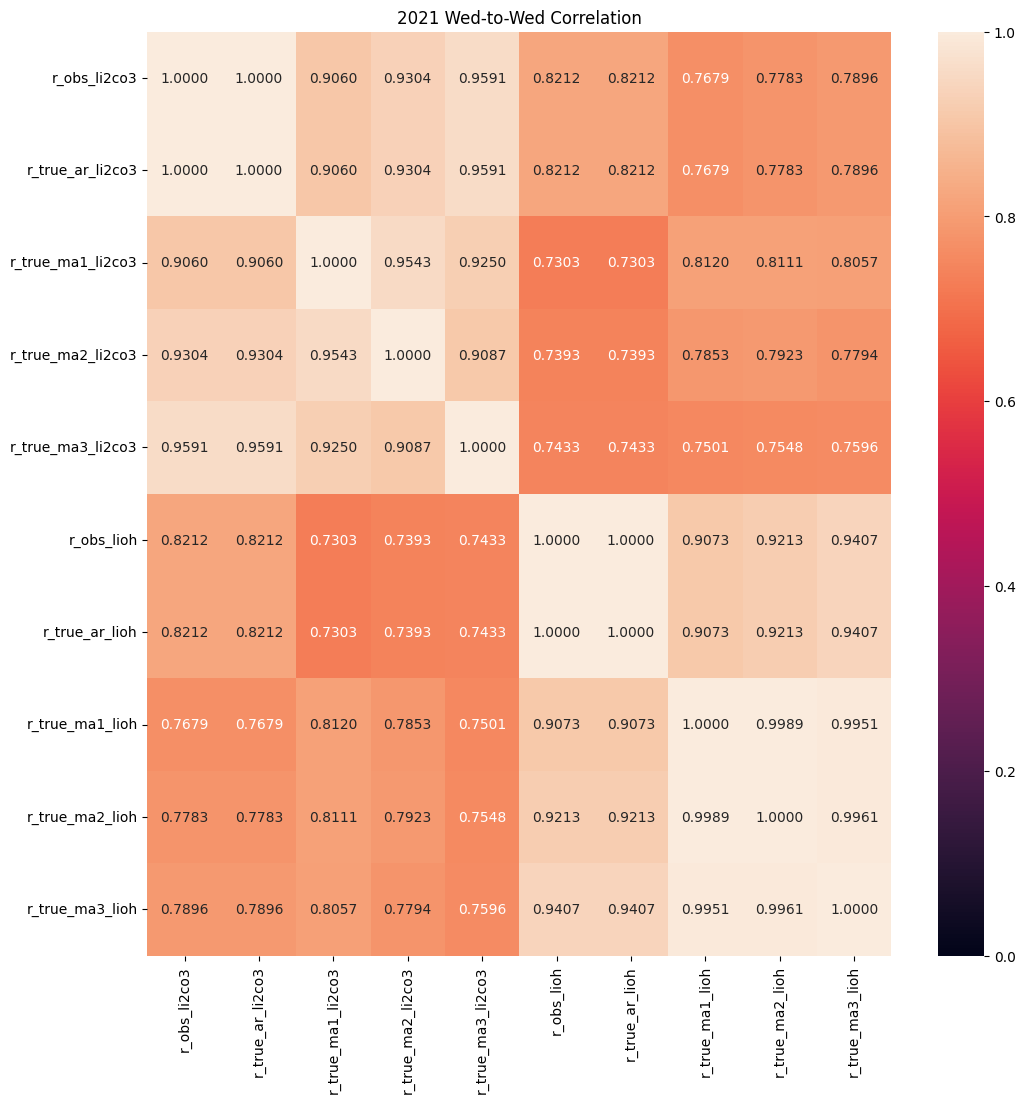

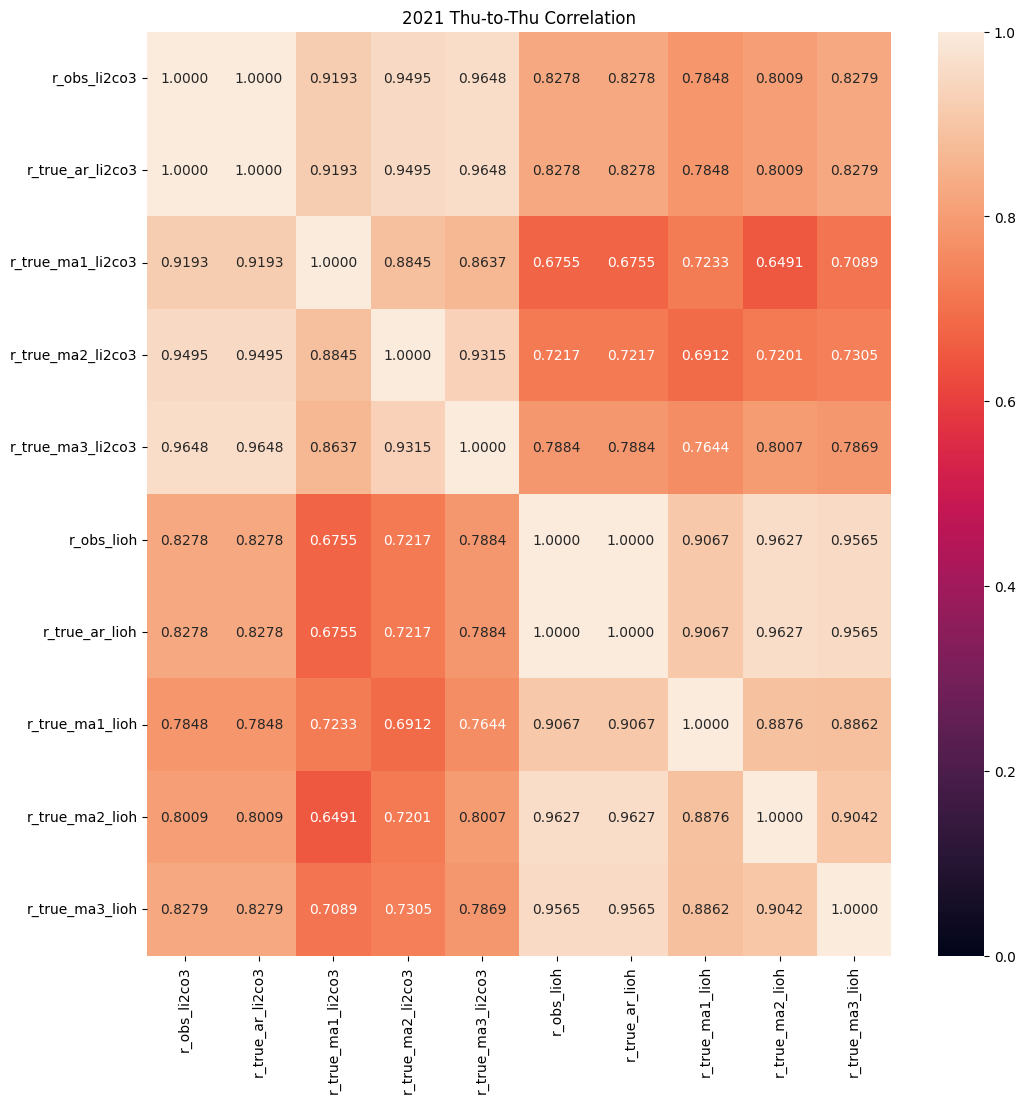

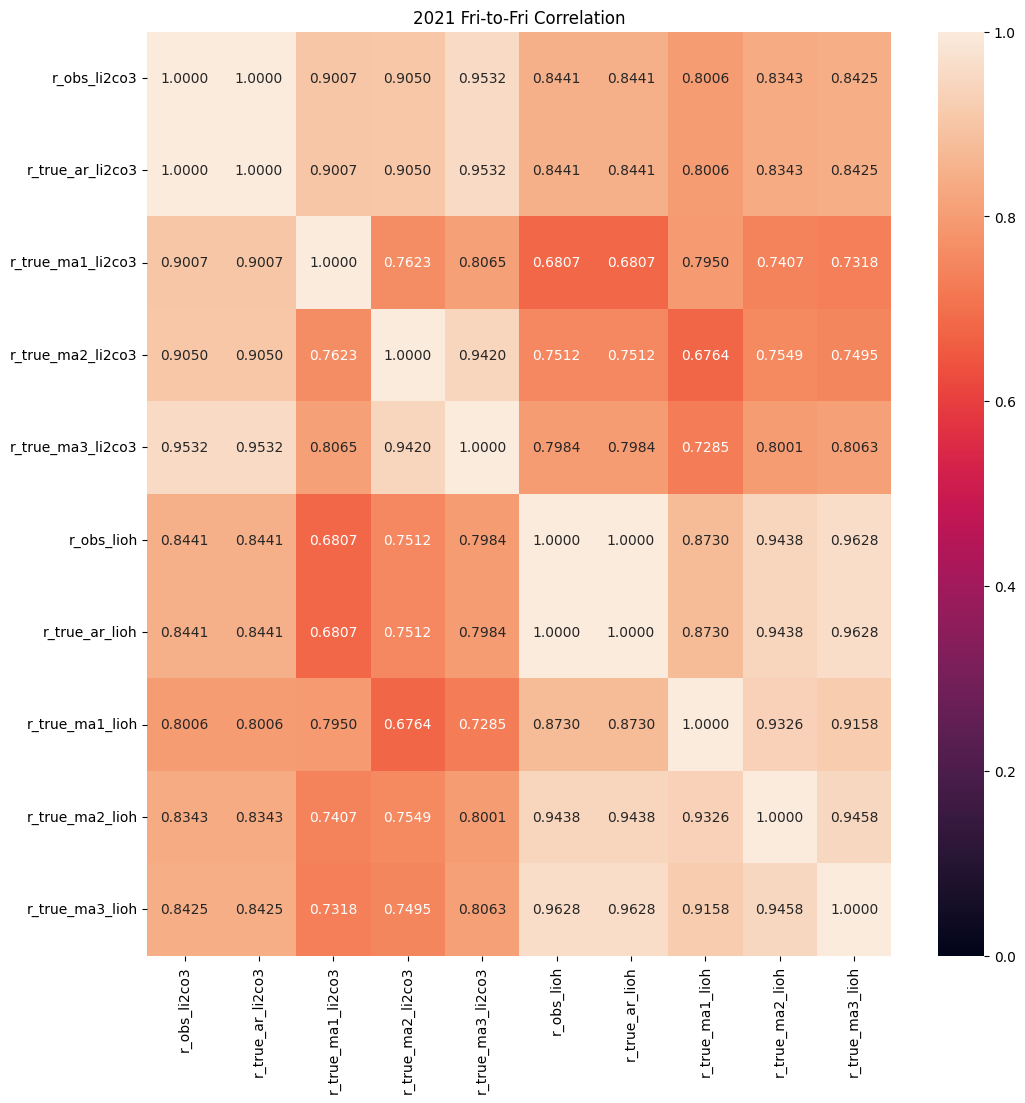

In [163]:
for dict_suffix in ['full','2021']:
    for i in range(5):
        temp1 = globals()[f'y_{i}_unsmooth_{dict_suffix}']['li2co3']
        temp2 = globals()[f'y_{i}_unsmooth_{dict_suffix}']['lioh']
        globals()[f'{dict_suffix}_{i}_merged'] = temp1.merge(temp2,left_index=True, right_index=True, suffixes=('_li2co3','_lioh'))
        fig = plt.figure(figsize = (12,12))
        plt.title(f'{dict_suffix} {calendar.day_abbr[i]}-to-{calendar.day_abbr[i]} Correlation')
        sns.heatmap(globals()[f'{dict_suffix}_{i}_merged'].corr(), annot=True, fmt = '.4f', vmin=0, vmax=1)
        plt.savefig(f'./unsmoothed_y_corr/{calendar.day_abbr[i]}_{dict_suffix}.png')


# Time Series Task 1

## Import Data from yahoo finance
See Upstream_companies.csv for stock details.

In [164]:
upstream = pd.read_csv('./Data/Upstream_companies.csv').iloc[:,1:] # first col is index
stock_currency = upstream.set_index('Stock')

# Select only from 2017 to 2023
start_date = '2017-09-08'
end_date = '2023-05-22'
up_price = {}
for s in stock_currency.index:
    up_price[s] = yf.download(s, start = start_date, end = end_date, interval='1d')['Adj Close'].to_frame()

    # Get currency of each stock
    currency_str = stock_currency.loc[s,'Currency']
    currency_converter = currency_str + 'CNY=X'

    # Get currency time seires and adjust Close price
    if currency_converter != 'CNYCNY=X':
        currency = yf.download(currency_converter, start = start_date, end = end_date, interval='1d')['Adj Close'].to_frame()
        up_price[s] = up_price[s].merge(currency, how='left', left_index=True, right_index=True, suffixes=(None,f'_cur'))
        up_price[s]['Adj Close_CNY'] = up_price[s]['Adj Close'] * up_price[s]['Adj Close_cur']
        up_price[s].drop(columns = ['Adj Close', 'Adj Close_cur'], inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Get mean and standard deviation for Mon-Mon, Tue-Tue, Wed-Wed, Thu-Thu, Fri-Fri

Result does not take currency and time zone into account

In [165]:
for i in range(5):
    globals()['x_' + str(i)] = {df: get_weekly(up_price[df],i) for df in up_price}
    # coampanies can be checked in dictionary for each weekday: x_0, x_1, x_2, x_3, x_4

def week_mean_std(i): # i: 0-4 for weekdays
    upstream[f'{calendar.day_abbr[i]}_Mean'] = upstream['Stock'].apply(lambda m: globals()[f'x_{i}'][m]['Weekly_Return'].mean())
    upstream[f'{calendar.day_abbr[i]}_Std'] = upstream['Stock'].apply(lambda m: globals()[f'x_{i}'][m]['Weekly_Return'].std())

for i in range(5):
    week_mean_std(i)

z = upstream.round(4)
z.to_csv('./Data/Upstream_companies.csv')

## First Order Autocorrelation

In [166]:
def plot_autocorr(i): # i: 0-4 for x_0, x_1, x_2, x_3, x_4
    for df in globals()[f'x_{i}']:
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        plot_acf(globals()[f'x_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, title = f'{df}_{calendar.day_abbr[i]} Autocorrelation', ax=ax[0])
        plot_pacf(globals()[f'x_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, method = 'ols', title = f'{df}_{calendar.day_abbr[i]} Partial Autocorrelation', ax=ax[1])
        # plt.savefig(f'./Autocorr_Graphs/{df}_{calendar.day_abbr[i]}.png')

# for i in range(5):
#     plot_autocorr(i)

## Zeros

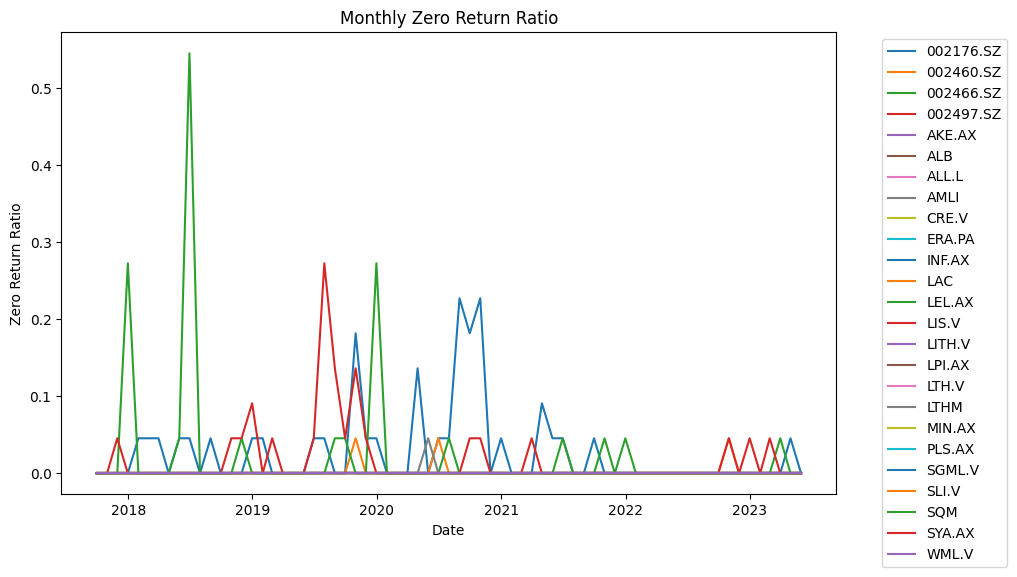

In [167]:
up_zeros = {df: zeros(up_price[df],'M') for df in up_price}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in up_zeros:
    plt.plot(up_zeros[df], label = df)

plt.title('Monthly Zero Return Ratio')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Time Series Task 2

### Part 1

In [168]:
# Merge Data
for i in range(5):
    for ydf in globals()[f'y_{i}']:
        for xdf in globals()[f'x_{i}']:
            globals()[f'y_{i}'][ydf] = globals()[f'y_{i}'][ydf].merge(globals()[f'x_{i}'][xdf]['Weekly_Return'], how='right', left_index=True, right_index=True, suffixes=(None,f'_{xdf}'))
        globals()[f'y_{i}'][ydf].drop(columns = ['Price','Daily_Return','Zeros'], inplace=True, errors='ignore')

KeyError: 'y_0'

In [ ]:
def reg_res(df): # Get regression result from df, e.g y_4['lioh']
    temp = df.copy()
    temp.dropna(inplace=True)
    Y = temp['Weekly_Return']
    stock_list = upstream.Stock.tolist()
    
    res_df = pd.DataFrame(index = ['constant', 'constant_pvalues', 'coefficient', 'coefficient_pvalue', 'hac_standard_error'])
    for s in stock_list:
        col = 'Weekly_Return_' + s
        X = temp[col]
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # Order: constant, constant_pvalues, coefficient, coefficient_pvalue, hac_standard_error
        res_df[s] = [model.params['const'], model.pvalues['const'], model.params[col], \
            model.pvalues[col], model.bse[col]]
    return res_df.transpose()

for i in range(5):
    for df in globals()[f'y_{i}']:
        print(df + f'_{i}')
        display(reg_res(globals()[f'y_{i}'][df]))


In [ ]:
t = pd.read_csv('./Data/Upstream_companies.csv').iloc[:,1:]
t